# Model of Spiking Neurons
## Getting Started

The code to generate spiking data from simulations of leaky integrate and fire neurons is can be found in `src/quadratic_integrate_and_fire.py`.
It uses the Brian2 simulator and creates a hdf5 file containing spike times (and meta data) for every set of parameters.

For example,
```
>>> python ./src/quadratic_integrate_and_fire.py -o ./dat/simulations/lif/test.hdf5 -d 300 -equil 60 -r 80
```
will run a simulation that lasts 300 seconds.

Here is a list of the model parameters, that can be specified at run time:
```
>>> python ./src/quadratic_integrate_and_fire.py -h 

  -h, --help            show this help message and exit
  -o FILE               output path
  -jA 45.0              AMPA current strength, in mV
  -jG 50.0              GABA current strength, in mV
  -jM 15.0              Minis (noise amplitude), in mV
  -r 80.0               Poisson rate (minis), all neurons, in Hz
  -tD 20.0              Characteristic recovery time, in seconds
  -s 42                 RNG seed
  -k 5                  Number of bridging axons
  -d 1200               Recording duration, in seconds
  -equil 120, --equilibrate 120
                        Equilibration duration, in seconds
  -stim off             if/how to stimulate: 'off', 'poisson'
  -stim_rate 20         additional rate in stimulated mods, in Hz
  -mod 0                modules to stimulate, e.g. `0`, or `02` for multiple
  --bridge_weight 1.0   synaptic weight of bridge neurons [0, 1]
  --inhibition_fraction 0.2
                        fraction of neurons that should be inhibitory
  --record-state-dt 25.0
                        time step for recording state variables, in ms.
                        use 0.5 to get smooth resource-rate cycles
```

After creating running a simulation, we can use the helper functions in `ana/plot_helper.py` to visualize the results.

In [8]:
# The autoreload extension allows you to tweak the code in the imported modules
# and rerun cells to reflect the changes.
# 
%load_ext autoreload
%autoreload 2
# this allows us to output the dictionary structure
%load_ext ipy_dict_hierarchy
# matplotlib settings to look decent in the notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# the helpers are in the `/ana/` folder.
import sys
sys.path.append("./../")
from ana import ana_helper as ah
from ana import plot_helper as ph
from ana import paper_plots as pp

# setup logging for notebook
import logging
logging.basicConfig(
    format="%(asctime)s | %(levelname)-8s | %(name)-12s | %(message)s",
    datefmt="%y-%m-%d %H:%M",
    level=logging.INFO,
)
log = logging.getLogger("notebook")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The ipy_dict_hierarchy extension is already loaded. To reload it, use:
  %reload_ext ipy_dict_hierarchy


In [4]:
# >>> python ./src/quadratic_integrate_and_fire.py -o ./dat/simulations/lif/test.hdf5 -d 300 -equil 60 -r 80
# lets load and take a look at the file we have created
h5f = ah.prepare_file("./../dat/simulations/lif/test.hdf5")
h5f

<class 'benedict.dicts.benedict'>
├── h5                                                                        
│   ├── filename ......................................................... str  ./../dat/si...
│   ├── dsetname ......................................................... str  /
│   └── file ............................................................ File
├── data                                                                      
│   ├── connectivity_matrix_sparse ................................... Dataset  (4915, 2)
│   ├── connectivity_segments ........................................ Dataset  (4915,)
│   ├── neuron_axon_end_to_end_distance .............................. Dataset  (160,)
│   ├── neuron_axon_length ........................................... Dataset  (160,)
│   ├── neuron_axon_segments_x ....................................... Dataset  (160, 232)
│   ├── neuron_axon_segments_y ....................................... Dataset  (160, 232)
│   ├── neuron_bri

The `h5f` above is just a nested dictionary that corresponds to a loaded hdf5 file. We use those a lot throught the analysis and plotting routines. Whenever an analysis is run, it can use details from known places and add the results directly to the `/ana/` dictionary (without writing to disk).

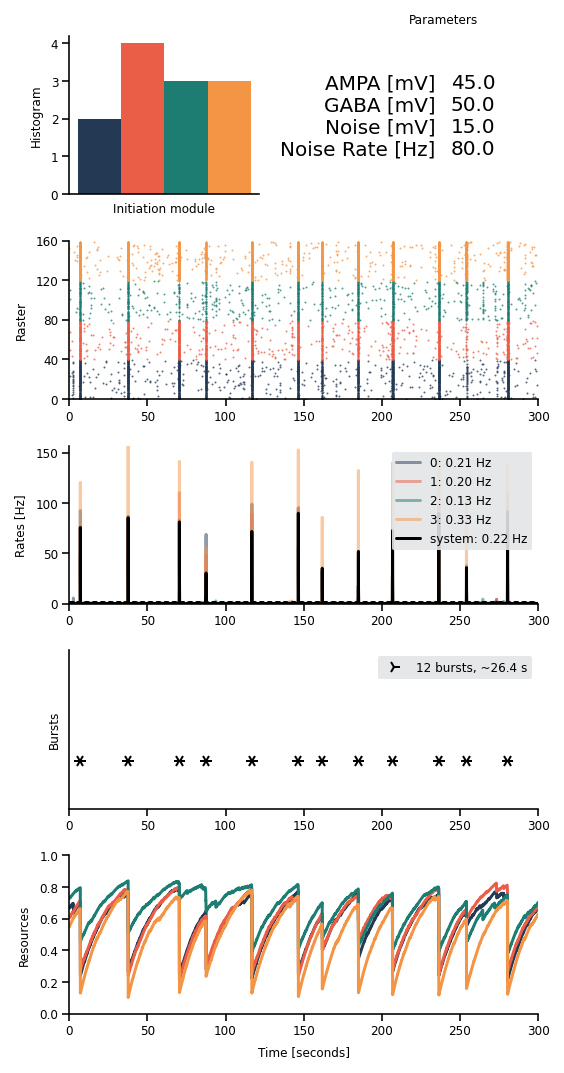

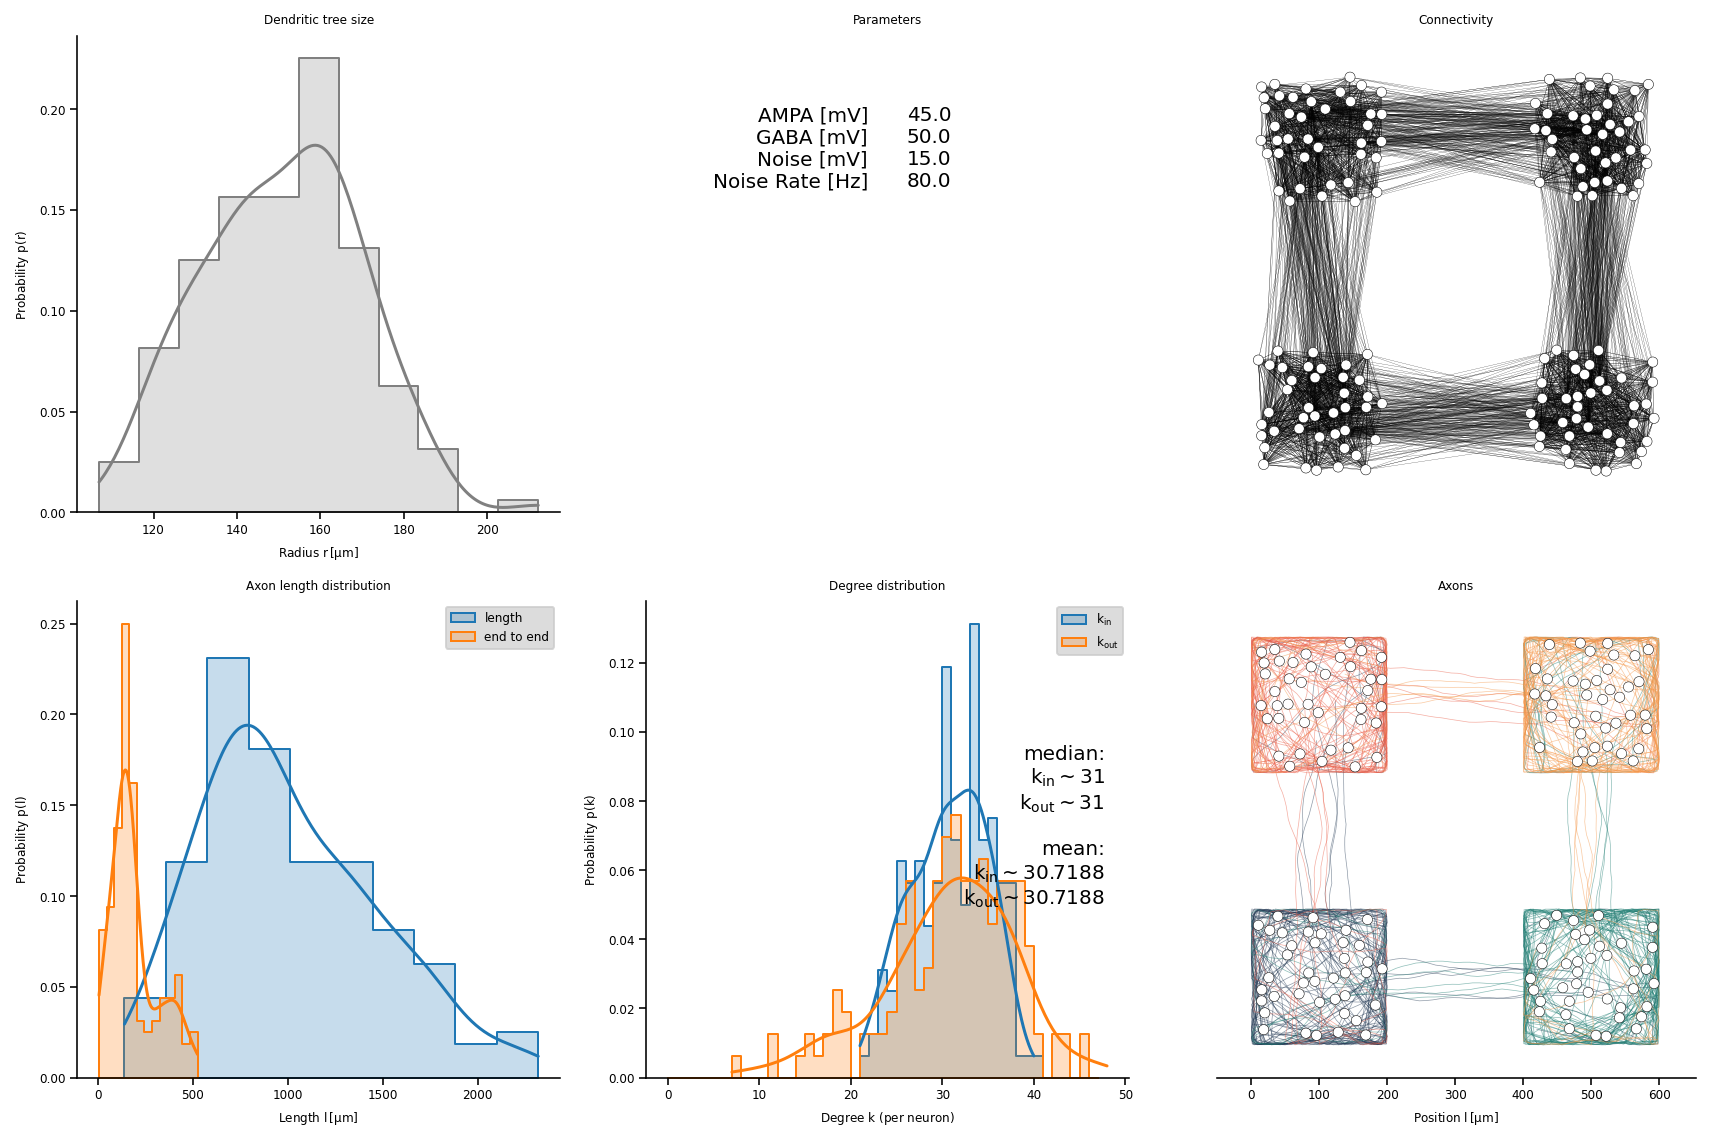

In [5]:
# silence the detailed outputs
ph.log.setLevel("ERROR")
# and produce overview panels for the loaded file
ph.overview_dynamic(h5f);
ph.overview_topology(h5f);
# Note, when using an interactive matplotlib backend, you can zoom and pan the figures

## Generating Data
We ran two sets of simulations: stimulating the whole system, or only two modules.
For example, the `python ./run/create_pars_for_global_stimulation.py` produces `run/parameters.tsv` with the parameter combinations we used, each line can be called from terminal.
By default, each line corresponds to one realization and produces one hdf5 file (like above) in `dat/simulations/lif/raw`.

Now you would call each line in a bash for-loop, or rather, have a look at `run/submit_to_cluster.sh`
For our example of 2k realizations and an SGE: `qsub -t 1-2000 ./run/submit_to_cluster.sh`

Note on compute time:
We used 50 realizations per coordinate and topology. Each of those (2k in total) runs approximately in real-time, and we simulate 30 minute recordings.

### Data for rate-resource cycles
To get the rate-resource cylces smooth, we have to record the resource variable during the simulations at high time resolution (which needs a lot of disk space, ~4GB for 30 min).
This can be enabled by passing `--record-state-dt 0.5` to `src/quadratic_integrate_and_fire.py`.
If you just want to reproduce the figures from the manuscript, you can quickly run a few simulations:
```
python ./src/quadratic_integrate_and_fire.py -o ./dat/simulations/lif/raw/highres_stim=off_k=-1_jA=45.0_jG=50.0_jM=15.0_tD=20.0_rate=80.0_rep=001.hdf5 -k -1 -d 1800 -equil 300 -s 6102 --record-state-dt 0.5 -r 80
python ./src/quadratic_integrate_and_fire.py -o ./dat/simulations/lif/raw/highres_stim=off_k=-1_jA=45.0_jG=50.0_jM=15.0_tD=20.0_rate=90.0_rep=001.hdf5 -k -1 -d 1800 -equil 300 -s 6102 --record-state-dt 0.5 -r 90
python ./src/quadratic_integrate_and_fire.py -o ./dat/simulations/lif/raw/highres_stim=off_k=1_jA=45.0_jG=50.0_jM=15.0_tD=20.0_rate=80.0_rep=001.hdf5 -k 1 -d 1800 -equil 300 -s 6002 --record-state-dt 0.5 -r 80
python ./src/quadratic_integrate_and_fire.py -o ./dat/simulations/lif/raw/highres_stim=off_k=1_jA=45.0_jG=50.0_jM=15.0_tD=20.0_rate=90.0_rep=001.hdf5 -k 1 -d 1800 -equil 300 -s 6002 --record-state-dt 0.5 -r 90
python ./src/quadratic_integrate_and_fire.py -o ./dat/simulations/lif/raw/highres_stim=off_k=5_jA=45.0_jG=50.0_jM=15.0_tD=20.0_rate=80.0_rep=001.hdf5 -k 5 -d 1800 -equil 300 -s 6102 --record-state-dt 0.5 -r 80
python ./src/quadratic_integrate_and_fire.py -o ./dat/simulations/lif/raw/highres_stim=off_k=5_jA=45.0_jG=50.0_jM=15.0_tD=20.0_rate=90.0_rep=001.hdf5 -k 5 -d 1800 -equil 300 -s 6102 --record-state-dt 0.5 -r 90
python ./src/quadratic_integrate_and_fire.py -o ./dat/simulations/lif/raw/highres_stim=off_k=10_jA=45.0_jG=50.0_jM=15.0_tD=20.0_rate=80.0_rep=001.hdf5 -k 10 -d 1800 -equil 300 -s 6202 --record-state-dt 0.5 -r 80
python ./src/quadratic_integrate_and_fire.py -o ./dat/simulations/lif/raw/highres_stim=off_k=10_jA=45.0_jG=50.0_jM=15.0_tD=20.0_rate=90.0_rep=001.hdf5 -k 10 -d 1800 -equil 300 -s 6202 --record-state-dt 0.5 -r 90
```

## Analysing
### Partial stimulation
The simulations with two targeted modules are analysed by the same script as the experiments
`ana/process_conditions.py`, it produces a pre-stim comparison.

The script has the (input and output) filenames hardcoded. It globs the input files that match the right file pattern, depending on `-t sim_partial`, `-t sim_partial_no_inhib` or `-t sim` (global stimulation) and creates and output file matching the `-t` argument.
For instance,
```
python ./ana/process_conditions.py -t sim_partial -i ./dat/simulations/lif/raw/ -o ./dat/simulations/lif/processed/
```
Scans all files in `/dat/simulations/lif/raw/` and outputs `./dat/simulations/lif/processed/k=5_partial.hdf5`.

### Outdated: Global stimulation (removed / reworked in Rev 1)
For the global stimulation, we mainly varied the input rate (`-r`) which ended up on the x-axis of most plots.

In order to combine the many runs in the `dat/simulations/lif/raw/` folder, we use the script in `ana/ndim_merge.py`. It takes a wildcarded file path, runs a lot of analysis, and merges the results into a high-dimensional (x-array like) hdf5 file. As this can take a while, it uses dask and can delegate to a cluster.
```
python ./ana/ndim_merge.py -i './dat/simulations/lif/raw/stim=off*jM=15*tD=20*.hdf5' -o ./dat/simulations/lif/processed/ndim.hdf5 -c num_cores
```

Both of the above scripts are wrappers (handling mostly the IO) around the lower-level analysis routines that can be found in `ana/ana_helper.py`. To reproduce where each observable in the processed dataframes comes from, I recommend to skim the scripts above and then jump to the corresponding part in the `ana_helper`.

## Note 23-01-09:
below are a plot functions that I used during revision 1, the have not been fully cleaned / documented, yet.

## Plots from the paper
### Partial Stimulation

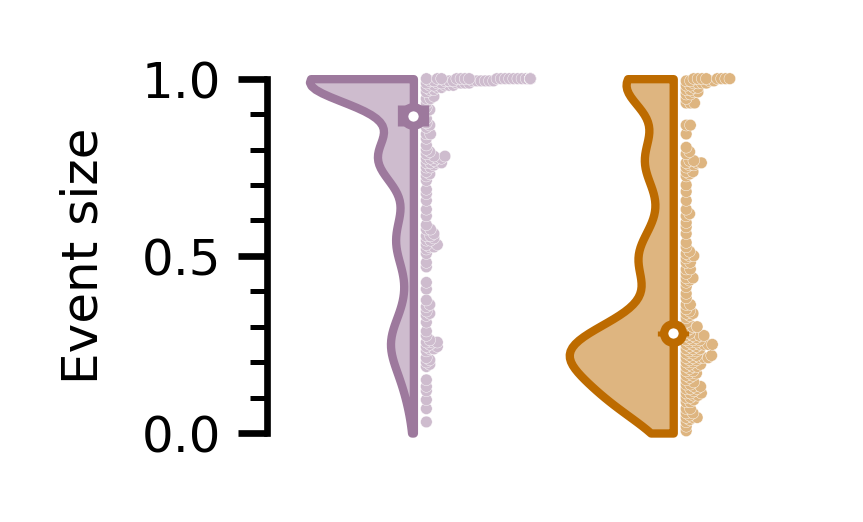

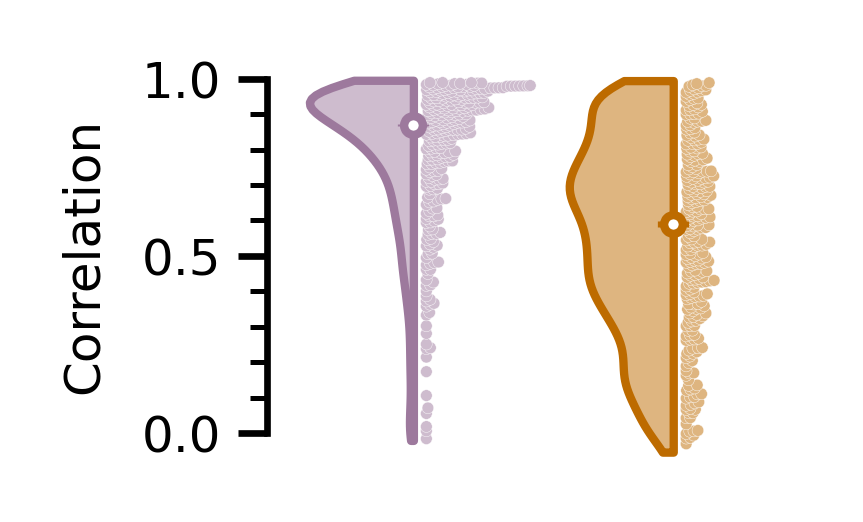

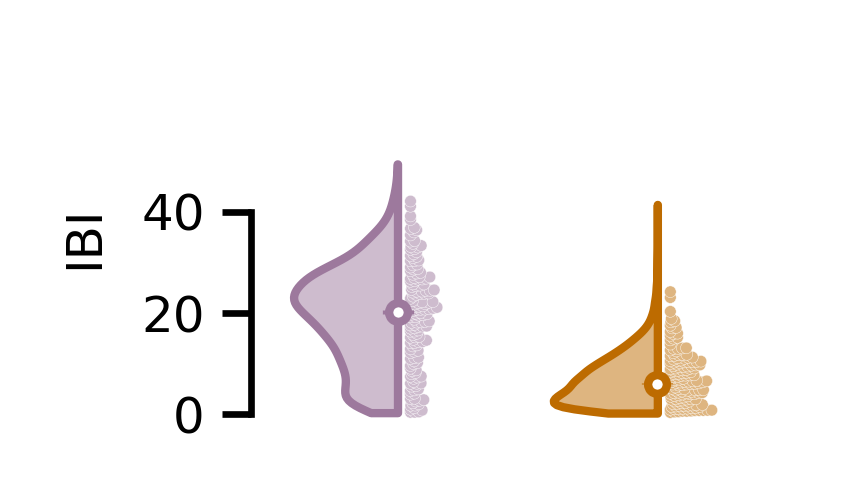

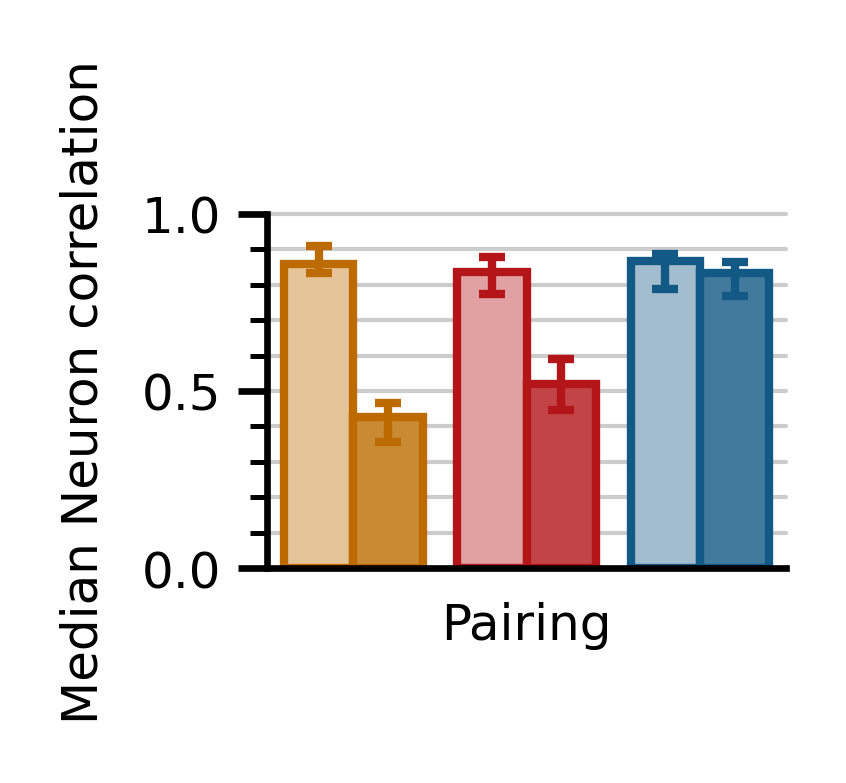

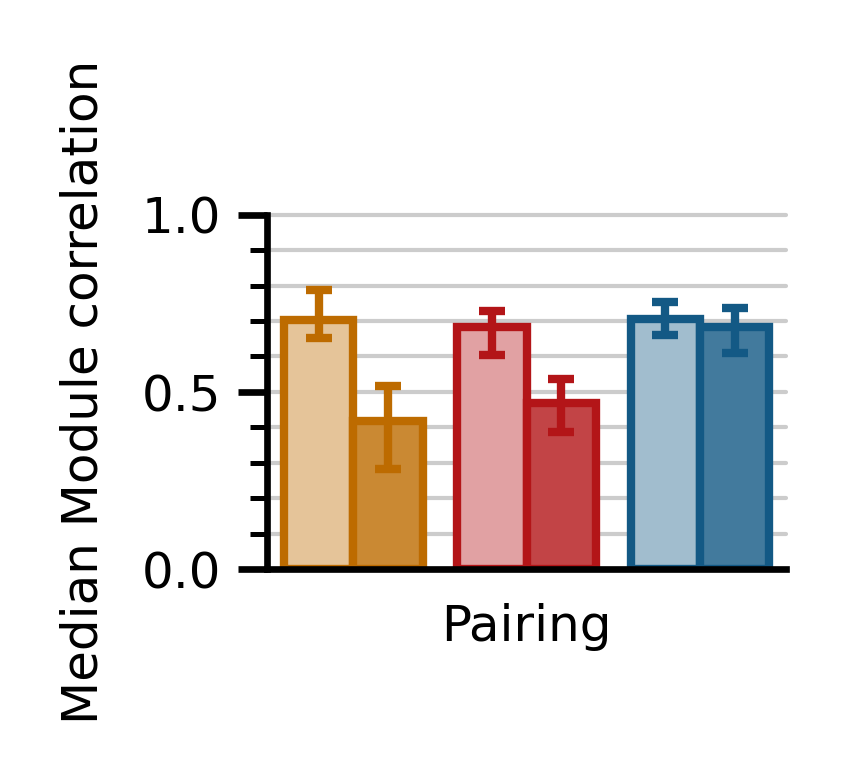

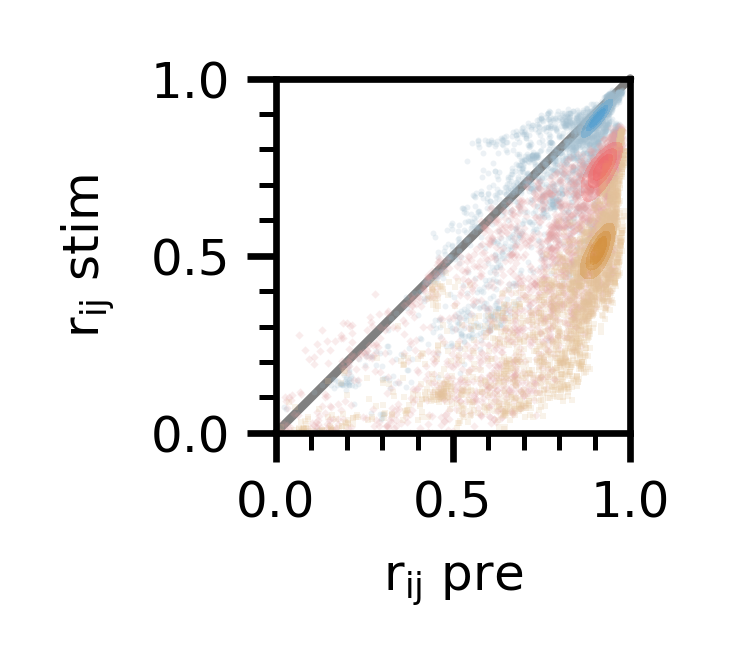

In [15]:
# fig 3 pooled violins and scatter for all realizations with k=3

pp.log.setLevel("INFO")
# print(pp.fig_3_r1.__doc__)
pp.show_xlabel = True
pp.show_ylabel = True
# for k in ["1", "3", "5", "10", "20", "-1"]:
for k in ["3"]:
    try:
        pp.fig_3_r1(
            # note: inconsistent file naming.
            pd_path = f"{pp.p_sim}/lif/processed_alpha/k={k}_partial.hdf5",
            out_suffix=f"_k={k}_partial",
            combine_panels=False,
        )
    except Exception as e:
        print(e)

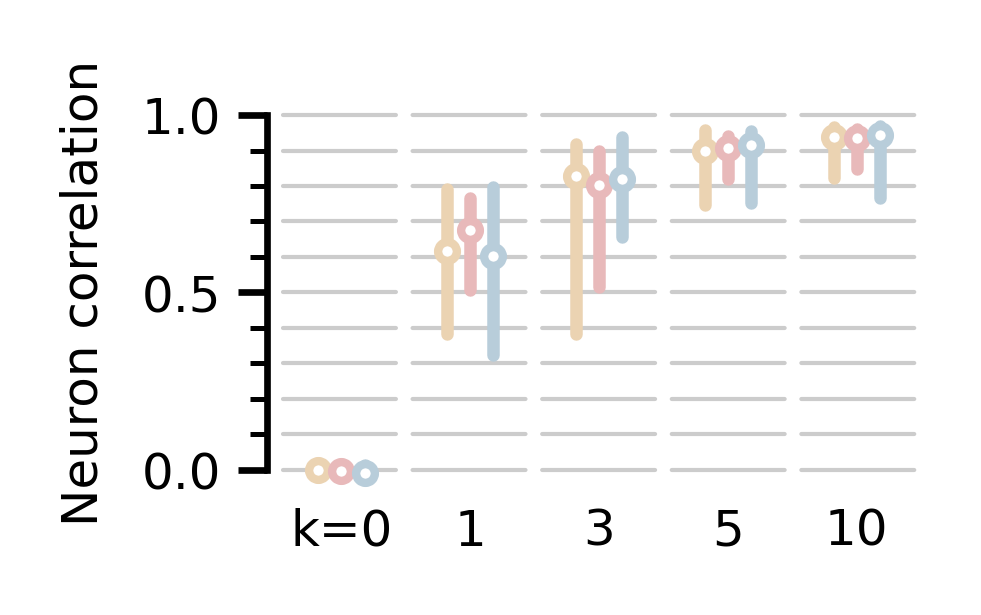

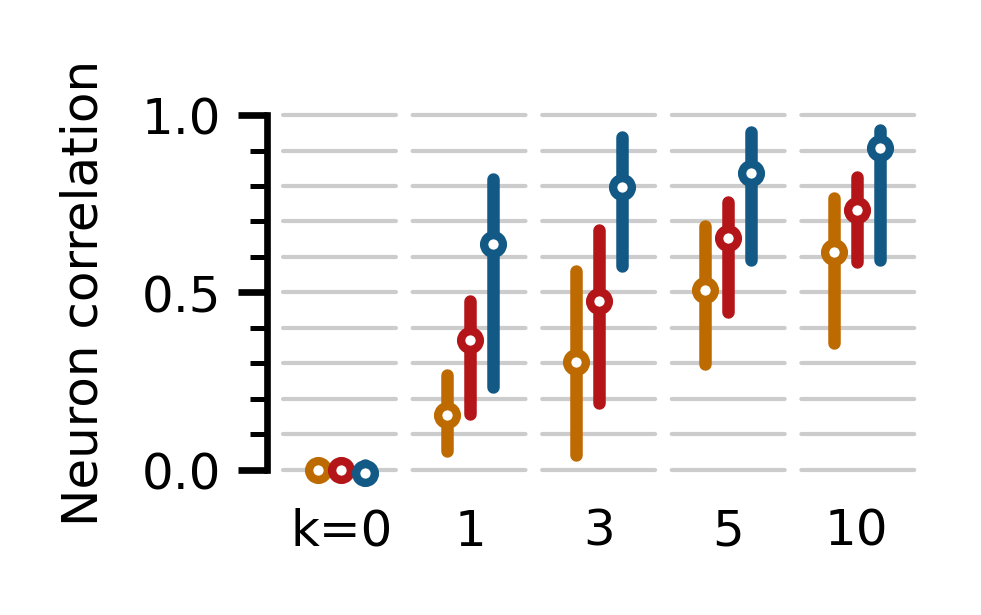

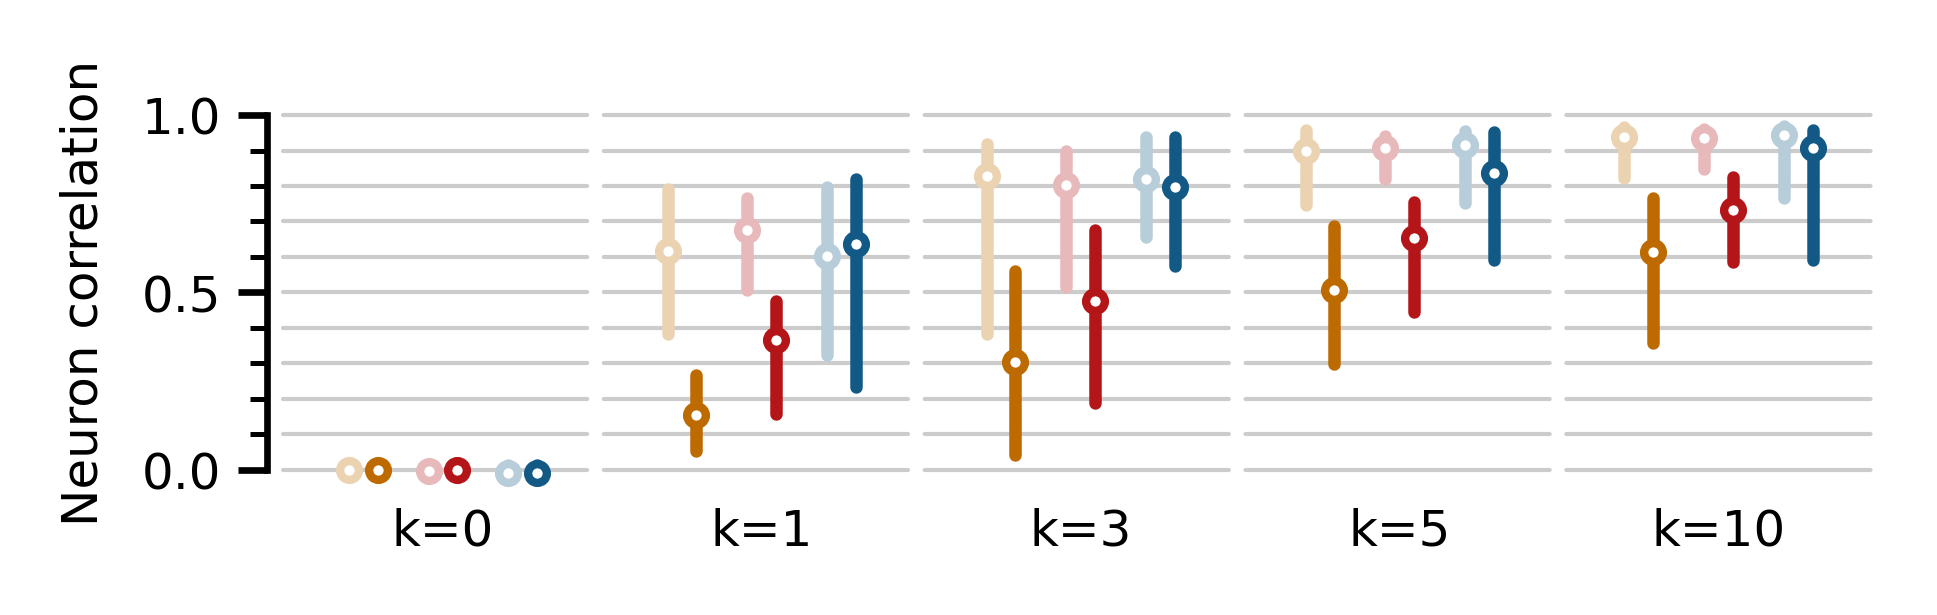

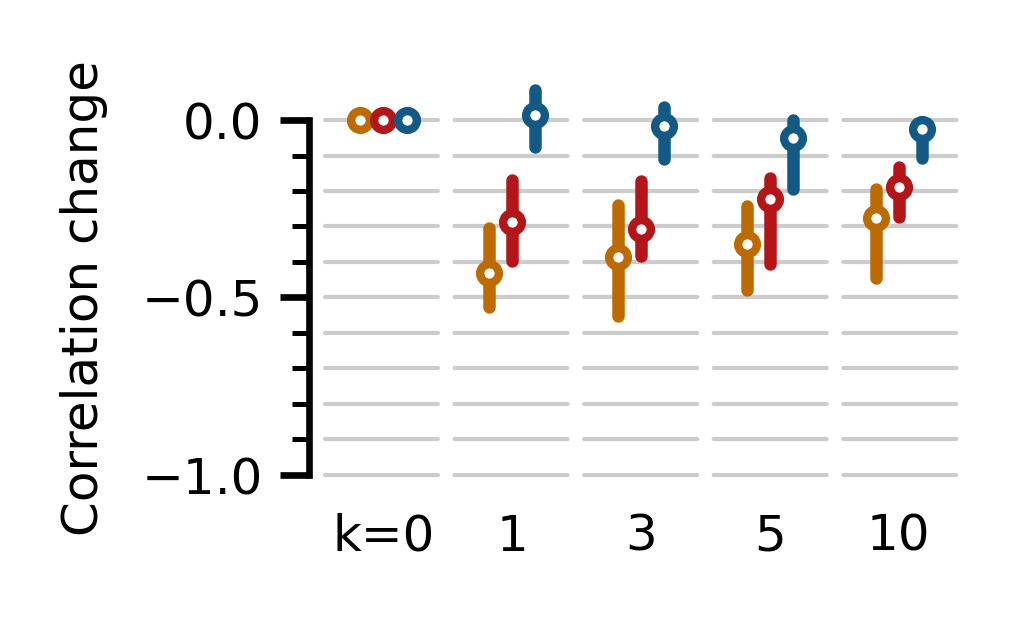

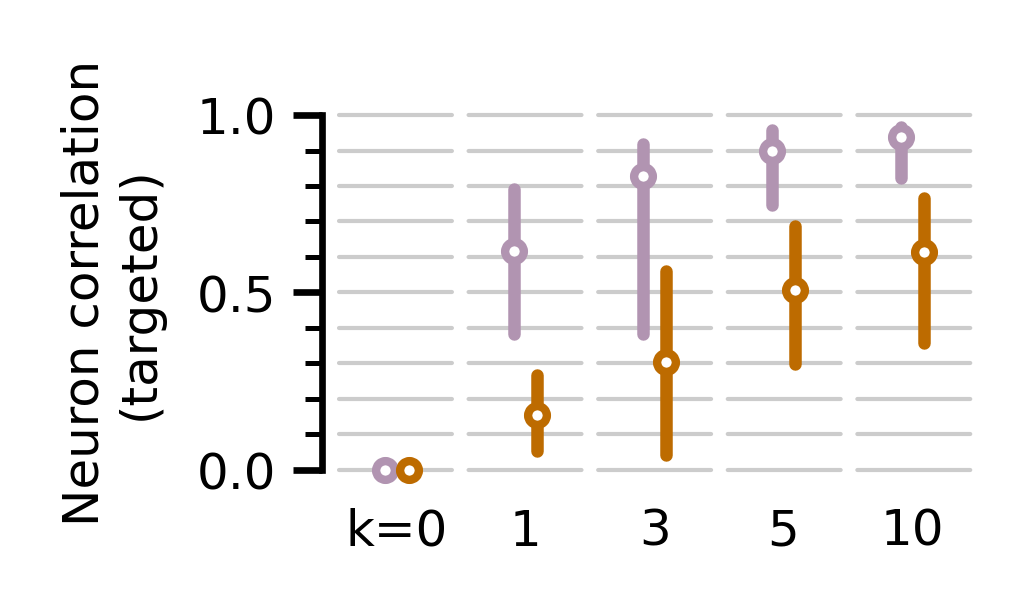

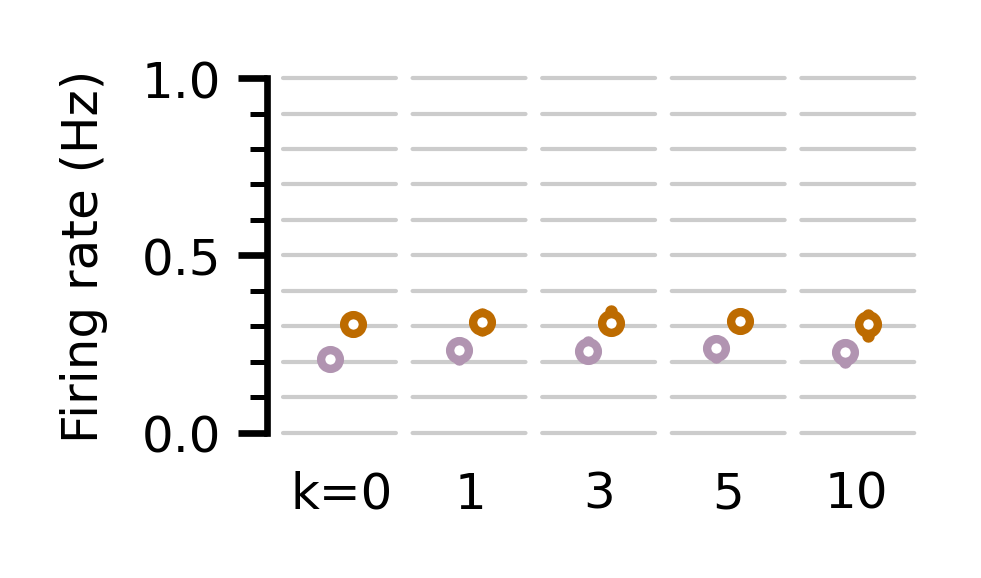

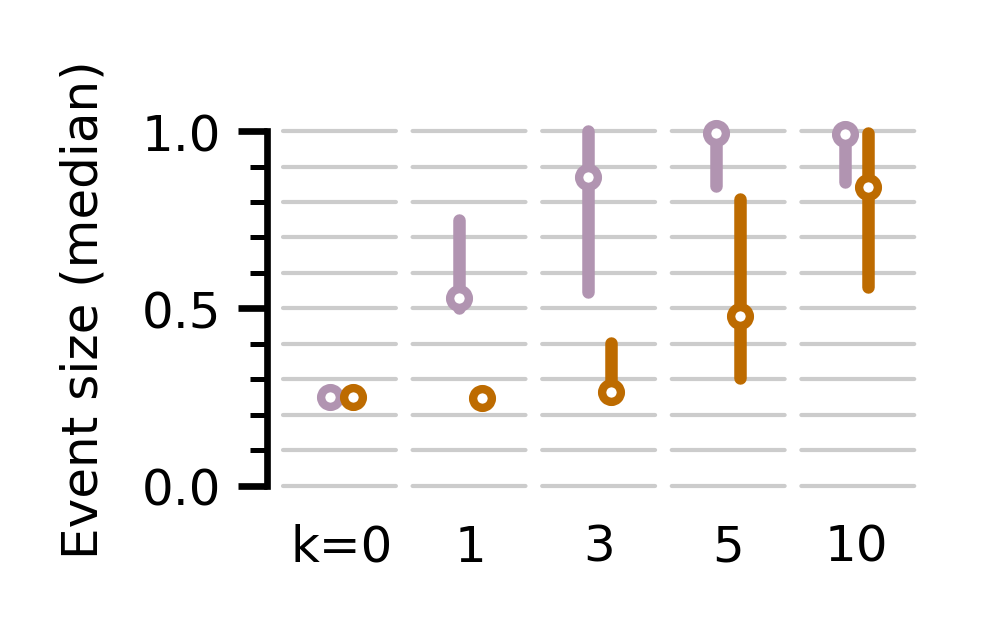

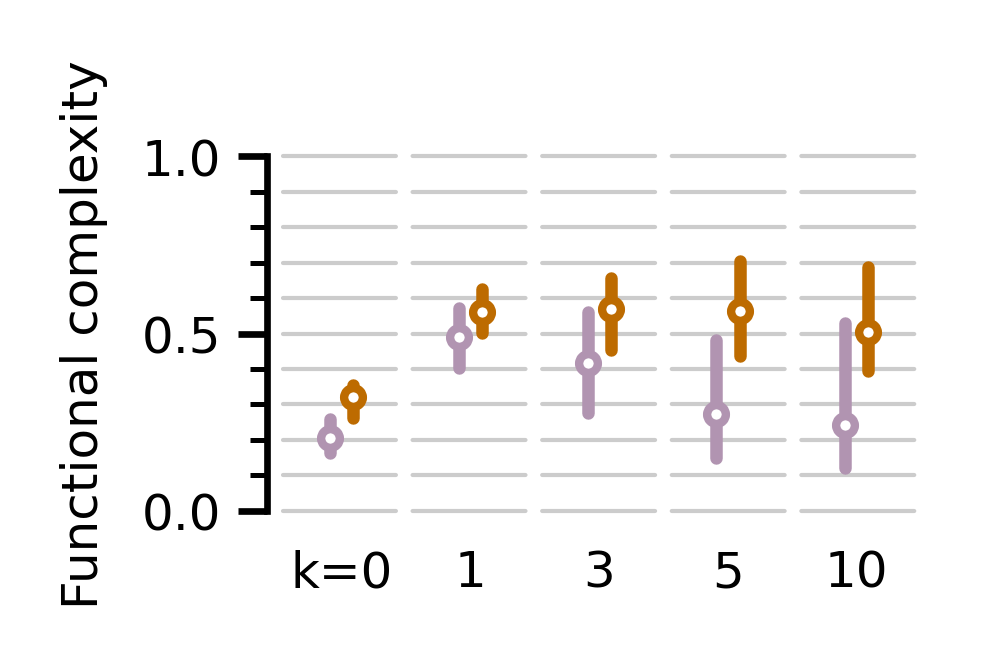

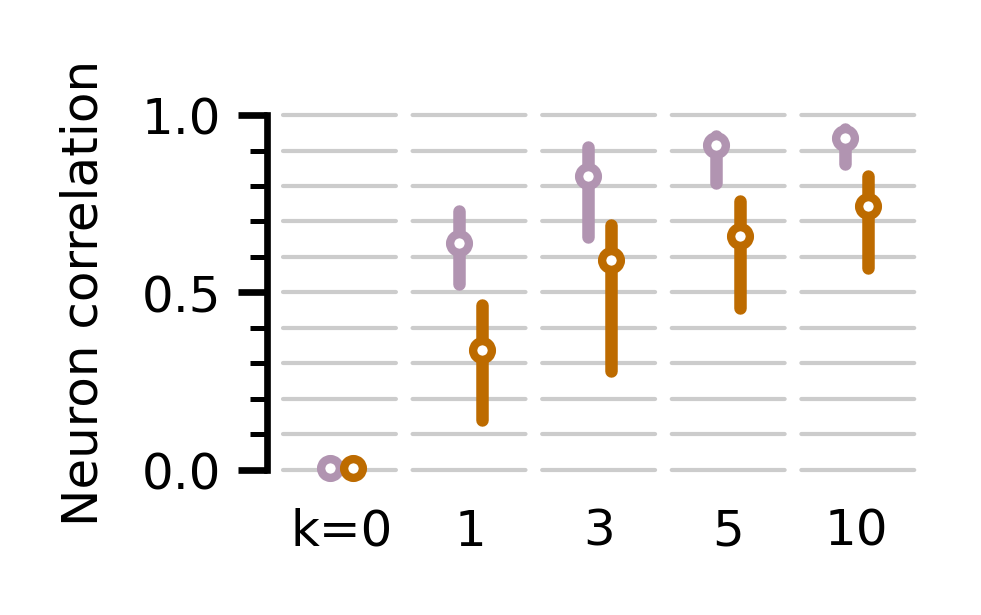

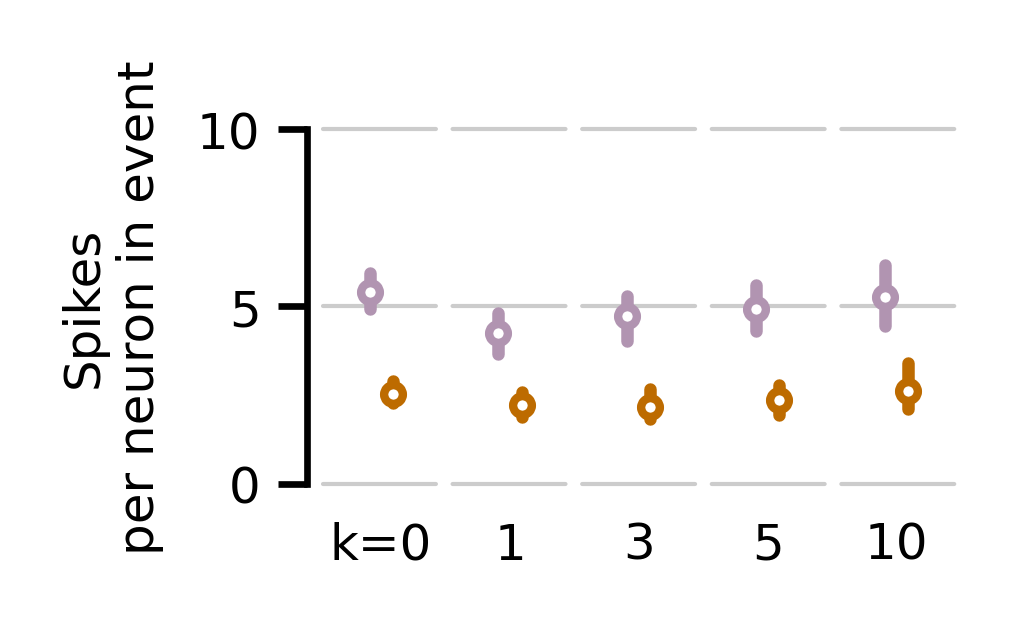

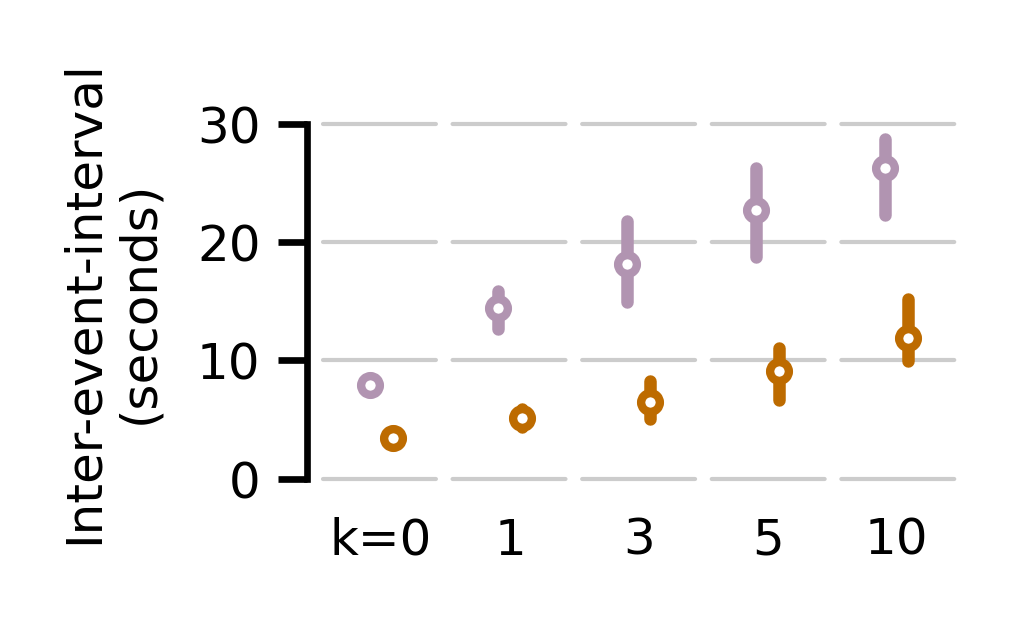

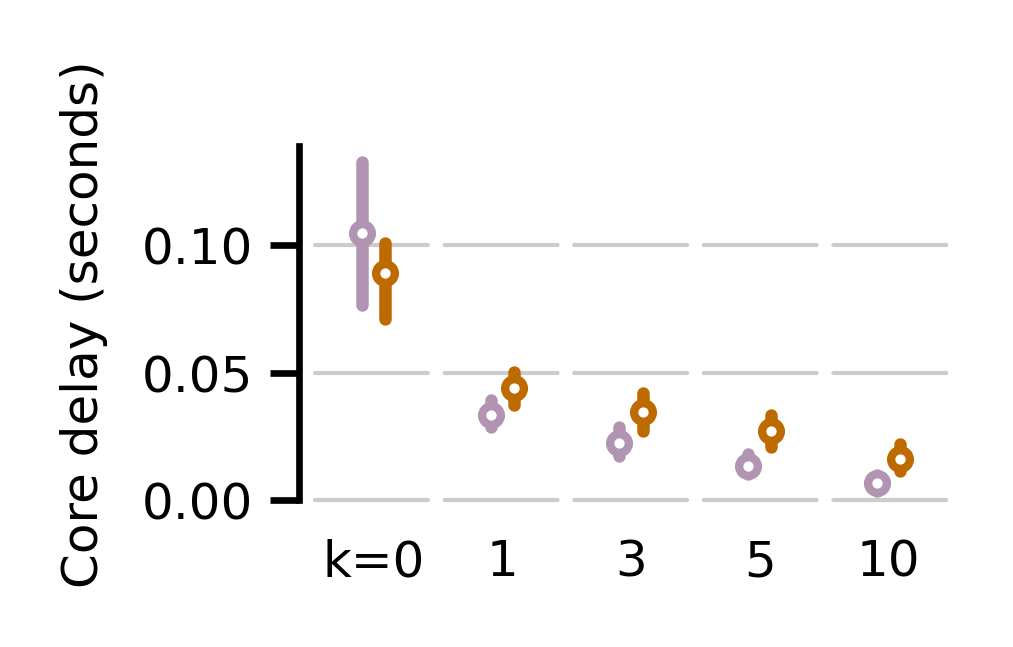

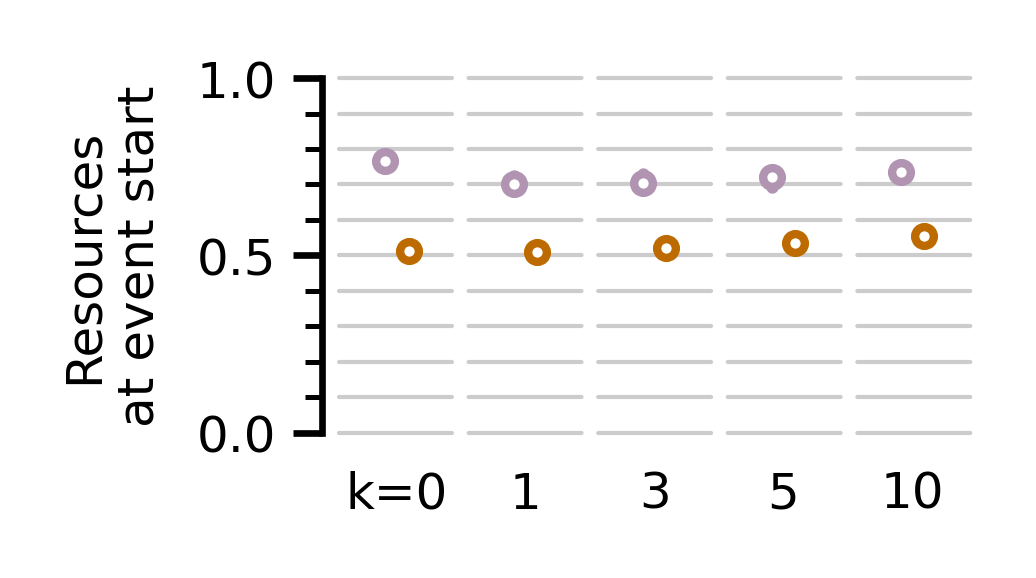

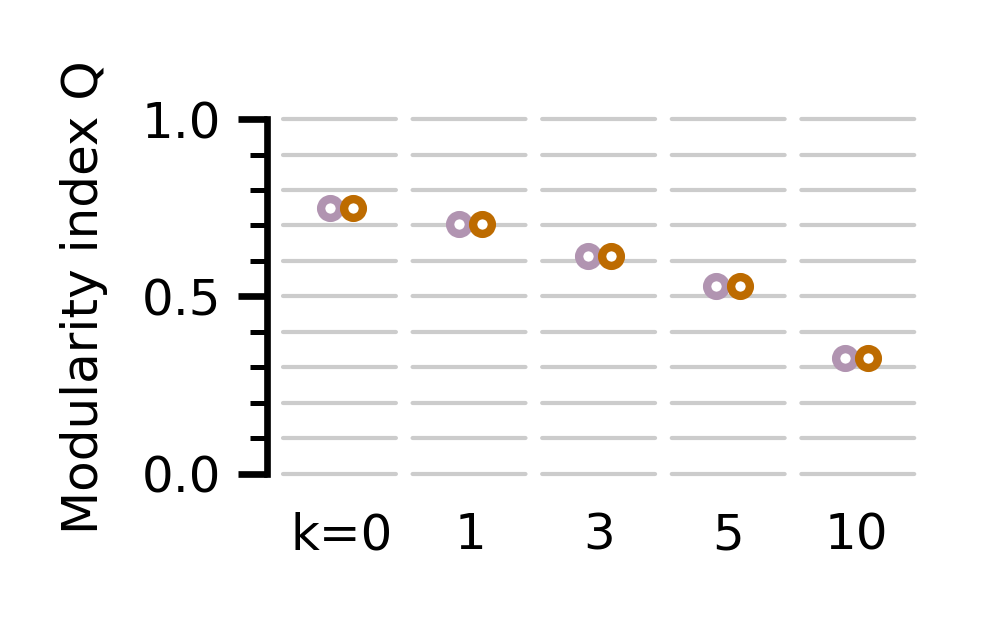

In [17]:
# fig 3, observables for different regions depending on k.
# used to be in figure 4, todo: refactor backend.

# print(pp.fig_4.__doc__)
pp.show_legend = False
pp.log.setLevel("INFO")
pp._error_bar_cap_style = "round"
pp.show_title = False
pp.show_ylabel = True
pp.show_xlabel = False
pp.fig_4_r1(
    pd_path=f"{pp.p_sim}/lif/processed/ndim.hdf5",
    out_prefix=f"{pp.p_fo}/sim_f4_",
    x_dim="k_inter",
)
#
pp._error_bar_cap_style = "butt"


In [19]:
# fig 3 table of plotted values for sm

pp.log.setLevel("INFO")
ds = pp.table_for_fig_3()
ds.rename(columns=pp._lif_labels, inplace=True)
ds.rename(columns=lambda x: x.replace("sys_median_correlation_", ""), inplace=True)
ds.to_excel(f"{pp.p_sim}/lif/processed/fig_3_table.xlsx", engine="openpyxl")
ds.to_latex(
    f"{pp.p_sim}/lif/processed/fig_3_table.tex",
    na_rep="",
    bold_rows=False,
    multirow=True,
    multicolumn=True,
    float_format="{:2.2f}".format,
)
ds


Event size (median)  Firing rate (Hz)  \
layout condition kind                                            
k=0    pre       median             0.250000          0.206194   
                 16                 0.250000          0.189246   
                 84                 0.250000          0.217658   
       stim      median             0.250000          0.305563   
                 16                 0.230750          0.285862   
                 84                 0.250000          0.318201   
k=1    pre       median             0.529688          0.233061   
                 16                 0.500000          0.208647   
                 84                 0.750000          0.253316   
       stim      median             0.246875          0.312025   
                 16                 0.237500          0.288694   
                 84                 0.262500          0.333863   
k=3    pre       median             0.870313          0.231390   
                 16                 0.547500          0.212607   
                 84                 1.000000          0.254493   
       stim      median             0.262500          0.309132   
                 16                 0.243750          0.292616   
                 84                 0.401000          0.343720   
k=5    pre       median             0.993750          0.238241   
                 16                 0.846000          0.213219   
                 84                 1.000000          0.258369   
       stim      median             0.478125          0.314321   
                 16                 0.303125          0.293682   
                 84                 0.809625          0.333149   
k=10   pre       median             0.990625          0.228423   
                 16                 0.856250          0.198858   
                 84                 1.000000          0.246102   
       stim      median             0.842188          0.305850   
                 16                 0.561000          0.272945   
                 84                 0.993750          0.332820   

                         Functional complexity  Neuron correlation  \
layout condition kind                                                
k=0    pre       median               0.205652            0.002899   
                 16                   0.164270           -0.003308   
                 84                   0.260150            0.012228   
       stim      median               0.320605            0.004847   
                 16                   0.261958            0.000049   
                 84                   0.354323            0.010336   
k=1    pre       median               0.491518            0.638318   
                 16                   0.401738            0.523381   
                 84                   0.573525            0.728363   
       stim      median               0.560095            0.336547   
                 16                   0.503138            0.138635   
                 84                   0.626379            0.465592   
k=3    pre       median               0.416341            0.829253   
                 16                   0.276912            0.655123   
                 84                   0.560761            0.909873   
       stim      median               0.569733            0.590571   
                 16                   0.454207            0.278142   
                 84                   0.658067            0.690454   
k=5    pre       median               0.271888            0.917132   
                 16                   0.147739            0.807420   
                 84                   0.483158            0.942118   
       stim      median               0.564548            0.659360   
                 16                   0.437693            0.455060   
                 84                   0.705386            0.758101   
k=10   pre       median               0.241228            0.936429   
                 16   

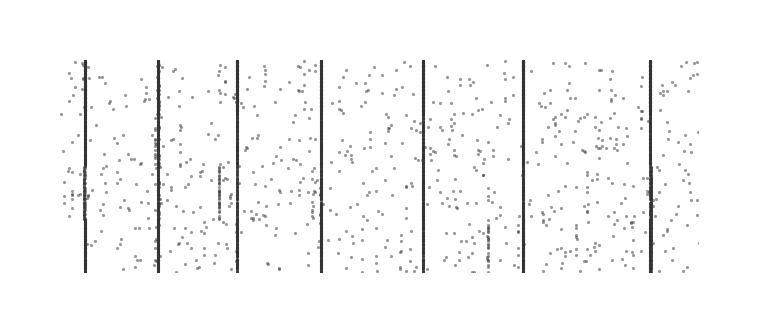

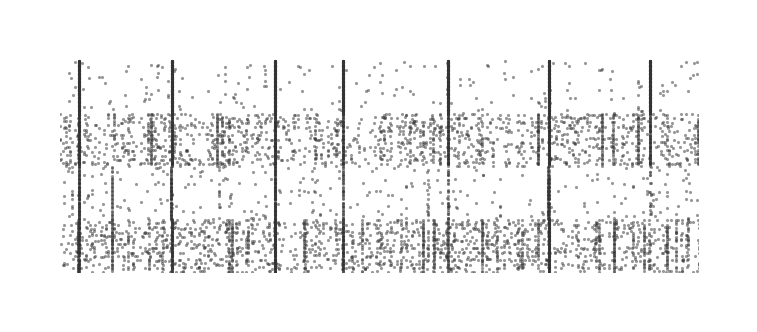

In [26]:
# fig 3 rasters
pp.show_xlabel = False
pp.show_ylabel = False
pp.show_title = False
pp.fig_3_r1_snapshots()

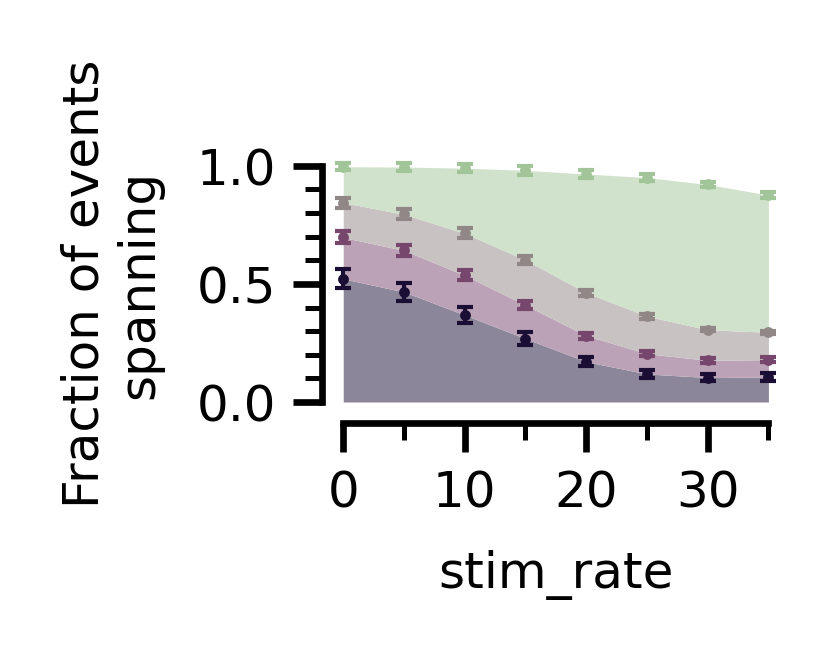

In [36]:
 # Fig 4 module contributions

pp.show_xlabel = True
pp.show_ylabel = True
pp.show_title = False

coords = pp.reference_coordinates
coords["k_inter"] = 3

ax = pp.sim_modules_participating_in_bursts(
    f"{pp.p_sim}/lif/processed/ndim.hdf5",
    simulation_coordinates=coords,
    xlim_for_fill=None,
    xlim_for_points=[0, 40],
    dim1="stim_rate",
    drop_zero_len=False,
)

ax.set_xlim(0, 35)
ax.set_xlabel("External input (Hz)" if pp.show_xlabel else "")
ax.set_ylabel("Fraction of events\nspanning" if pp.show_ylabel else "")


pp.sns.despine(ax=ax, offset=2.5)
pp.cc.set_size(ax, w=1.8, h=1.0, l=0.8, b=0.5, r=0.2, t=0.2)

ax.get_figure().savefig(f"{pp.p_fo}/lif_partial_modules_participating_in_bursts.pdf", dpi=300)

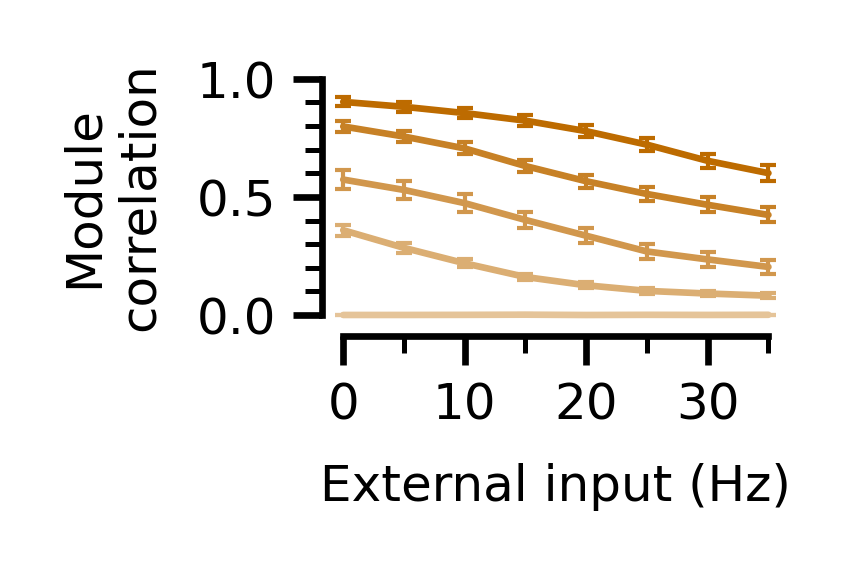

In [37]:
# Fig 4 module correlation

pp.log.setLevel("INFO")

pp.show_xlabel = True
pp.show_ylabel = True
pp.show_title = False

dset = pp.nh.load_ndim_h5f(f"{pp.p_sim}/lif/processed/ndim.hdf5")
cc = pp.cc

ax = None
for kdx, k in enumerate([0, 1, 3, 5, 10]):
    coords = pp.reference_coordinates.copy()
    coords["k_inter"] = k
    coords["stim_mods"] = "02"
    coords["rate"] = 80.0
    ax = pp.sim_plot_obs_from_ndim(
        dset = dset,
        coords = coords,
        observable = "mod_median_correlation_within_stim",
        x_dim = "stim_rate",
        ax = ax,
        errortype="sem",
        estimator="mean",
        color= cc.alpha_to_solid_on_bg(pp.colors["stim"], cc.fade(kdx, 5, invert=True)),
        clip_on=False,
    )

ax.set_xlim(0, 35)
ax.set_ylim(0, 1)
ax.xaxis.set_major_locator(pp.matplotlib.ticker.MultipleLocator(10))
ax.xaxis.set_minor_locator(pp.matplotlib.ticker.MultipleLocator(5))
ax.yaxis.set_major_locator(pp.matplotlib.ticker.MultipleLocator(0.5))
ax.yaxis.set_minor_locator(pp.matplotlib.ticker.MultipleLocator(0.1))
ax.set_xlabel("External input (Hz)" if pp.show_xlabel else "")
ax.set_ylabel("Module\ncorrelation" if pp.show_ylabel else "")

pp.sns.despine(ax=ax, offset=2.5)
pp.cc.set_size(ax, w=1.8, h=1.0, l=0.8, b=0.5, r=0.2, t=0.2)
ax.get_figure().savefig(f"{pp.p_fo}/f4_lif_correlation_vs_rate.pdf", dpi=300)


In [ ]:
# resource cycles, rasters, topology

# print(pp.fig_4_snapshots.__doc__)
pp.show_xlabel = False
pp.show_ylabel = False
pp.show_title = False
pp.fig_4_r1_snapshots(
    k_in=30,
    do_rasters=True,
    do_topo=True,
    # plotting resource cycles takes very long.
    do_cycles=True,
    out_prefix=f"{pp.p_fo}/sim_s3_lif_",
)

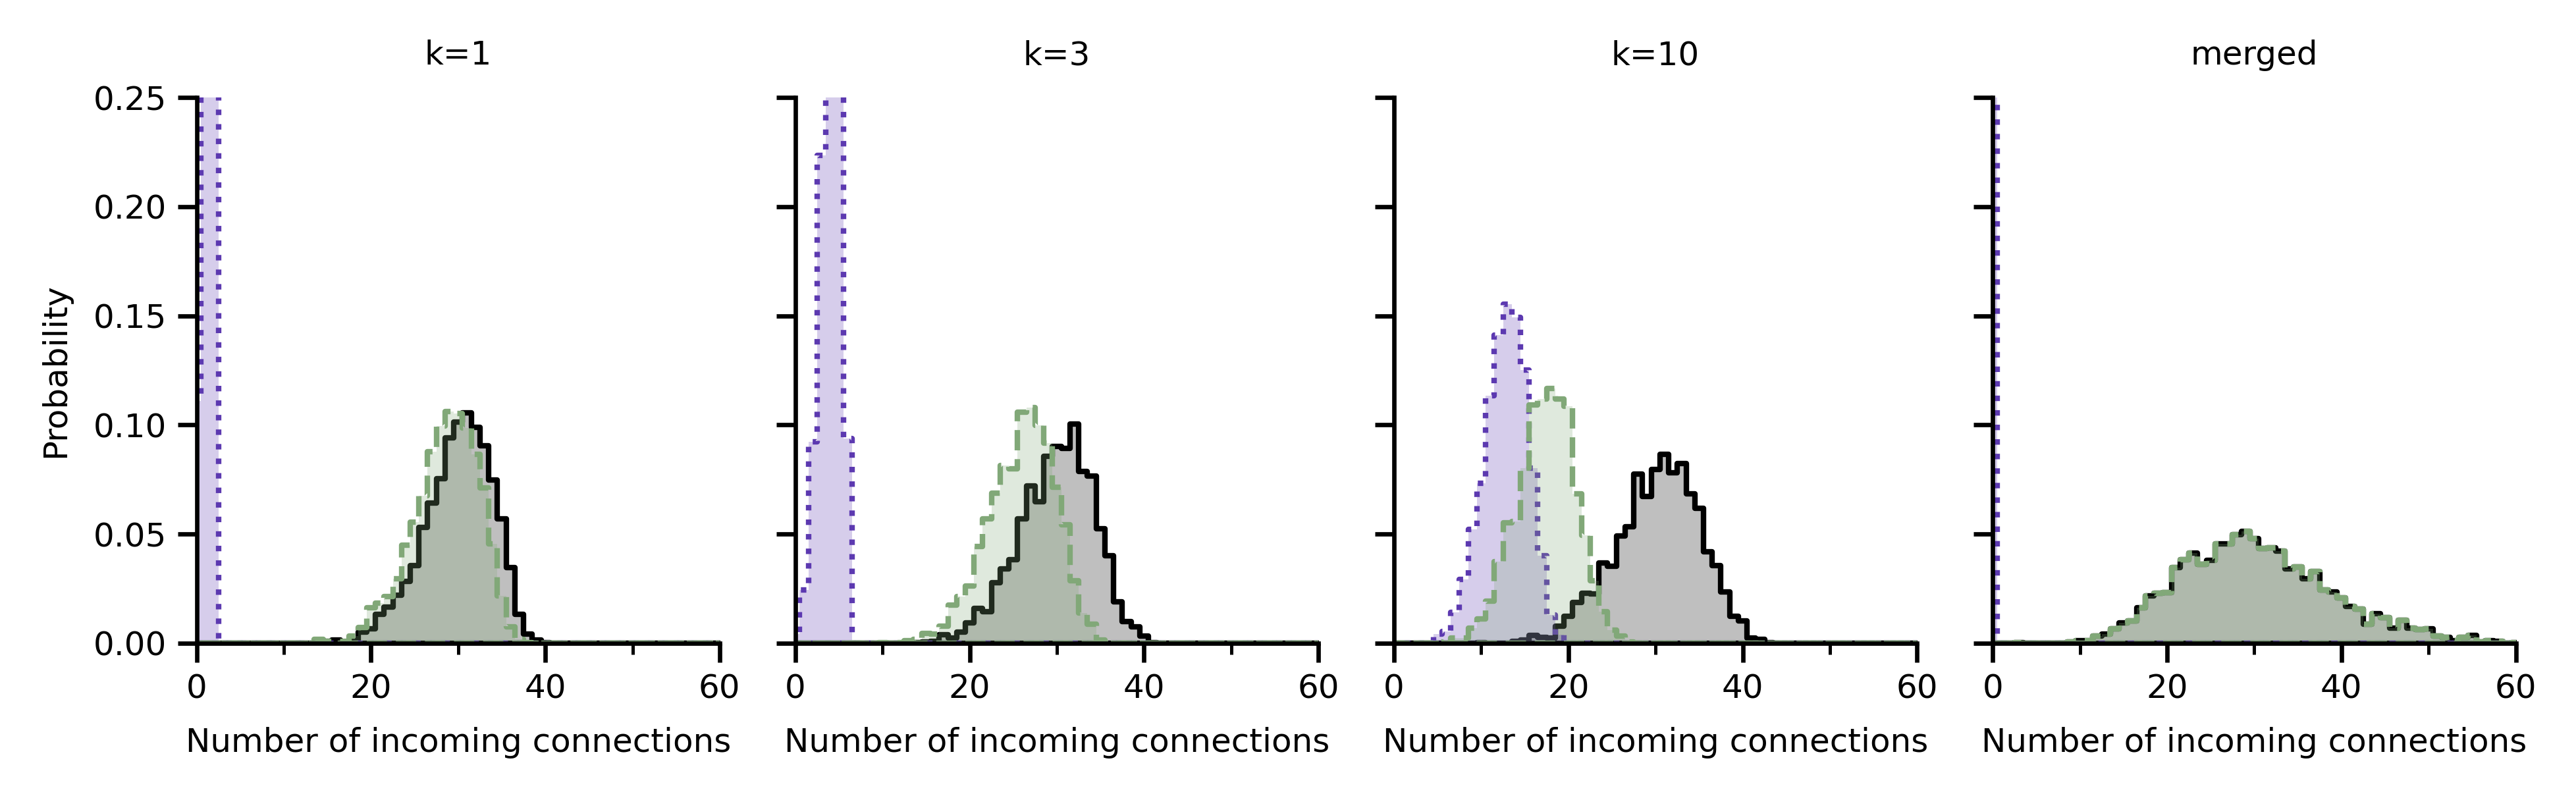

In [29]:
# degree distributions

import matplotlib.pyplot as plt
from src import topology as topo

pp.show_title = True
pp.show_xlabel = True
pp.show_ylabel = True

k_in_target = 30

fig, axes = plt.subplots(nrows=1, ncols=4, sharex=True, sharey=True, figsize=(6.5, 2))
for idx, k in enumerate([1, 3, 10, -1]):
    a = topo.find_alpha_for_target_in_degree(
        k_inter=k, k_in_target=k_in_target, rerun=False
    )
    ax = axes[idx]
    # seaborns distplot makes glitchy legend entries, we fix them in post.
    # black -> total
    # purple -> external
    # green -> internal
    pp.sim_degrees_sampled(k_inter=k, num_reps=20, ax=ax, par_alpha=a)
    if pp.show_title:
        ax.set_title(f"k={k}" if k != -1 else "merged")

    ax.set_xlim(0,60)
    fig.tight_layout()
    fig.savefig(f"{pp.p_fo}/in_degrees_kin={k_in_target}.pdf", bbox_inches="tight")


23-01-09 13:39 | INFO     | ana.paper_plots | 
23-01-09 13:39 | INFO     | ana.paper_plots | # simulation with two targeted modules
23-01-09 13:39 | INFO     | ana.paper_plots | 
23-01-09 13:39 | INFO     | ana.paper_plots | 
23-01-09 13:39 | INFO     | ana.paper_plots | barplot rij paired for simulations
23-01-09 13:39 | INFO     | ana.paper_plots | scattered 2d rij paired for simulations


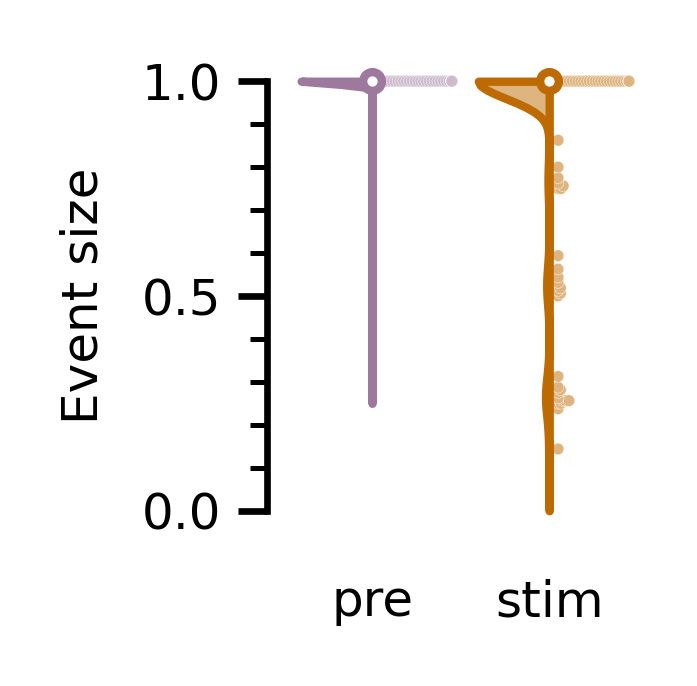

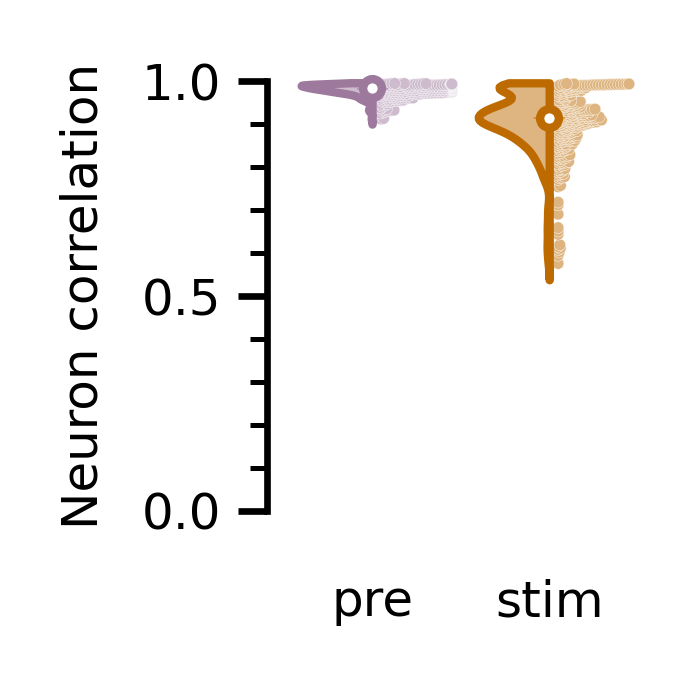

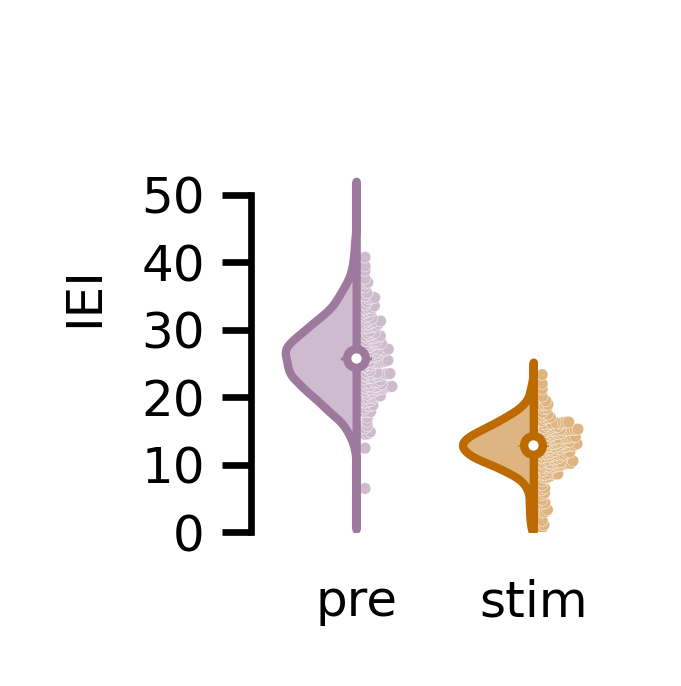

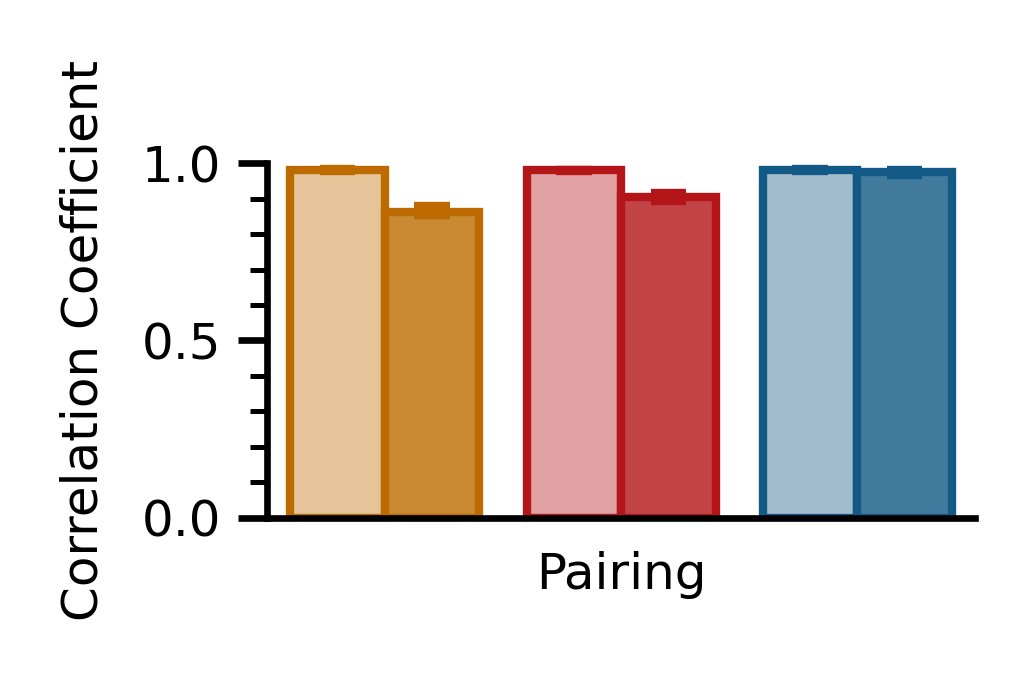

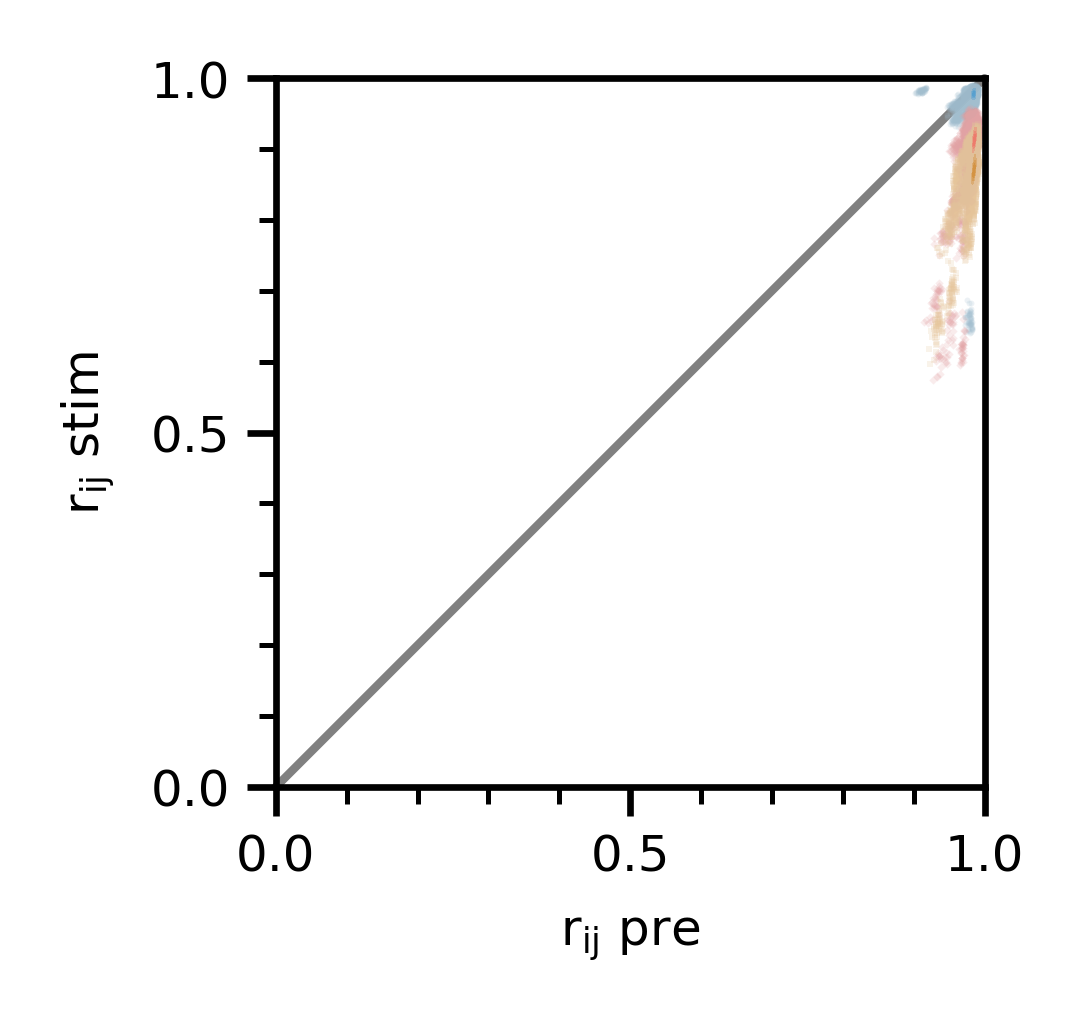

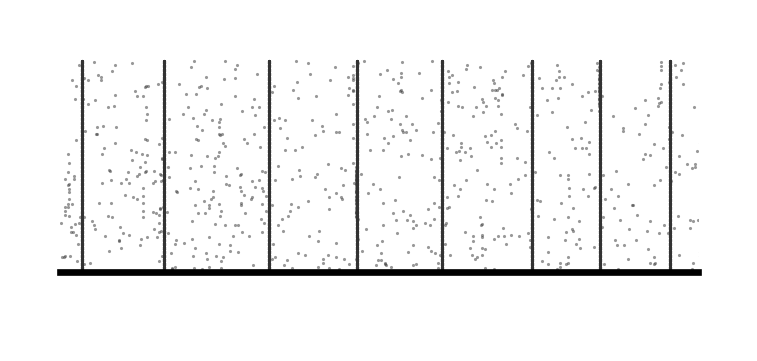

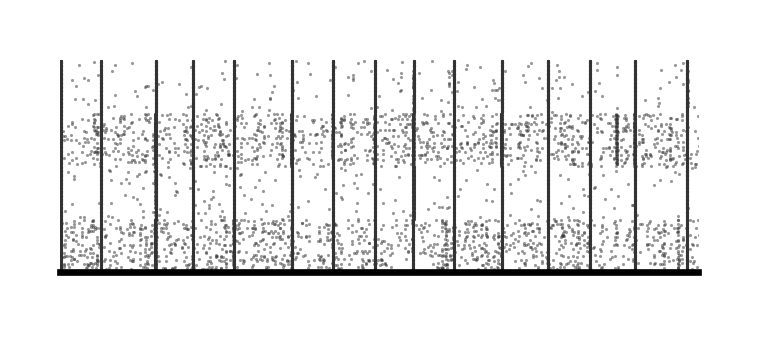

In [23]:
# "Blocking Inhibition" by setting jG=0

pp.show_xlabel = False
pp.show_ylabel = True
pp.show_title = False

pp.fig_3(
    pd_path=f"{pp.p_sim}/lif/processed/k=3_partial_no_inhib.hdf5",
    raw_paths = [
        f"{pp.p_sim}/lif/raw/stim=02_k=3_kin=30_jA=45.0_jG=0.0_jM=15.0_tD=20.0_rate=80.0_stimrate=0.0_rep=001.hdf5",
        f"{pp.p_sim}/lif/raw/stim=02_k=3_kin=30_jA=45.0_jG=0.0_jM=15.0_tD=20.0_rate=80.0_stimrate=20.0_rep=001.hdf5",
    ],
    out_prefix=f"{pp.p_fo}/sim_s6_",
)

In [ ]:
# A Reviewer answer, dependence on bin size
# runs the same as fig 4 but loads different preprocessed files.
# print(pp.fig_4.__doc__)
pp.show_legend = False
pp.log.setLevel("INFO")
pp._error_bar_cap_style = "round"
pp.show_title = False
pp.show_ylabel = True
pp.show_xlabel = False
pp.fig_4_r1(
    pd_path=f"{pp.p_sim}/lif/processed/ndim_250rij_22-12-19.hdf5",
    out_prefix=f"{pp.p_fo}/sim_sr_rij250_",
    x_dim="k_inter",
)
#
pp._error_bar_cap_style = "butt"

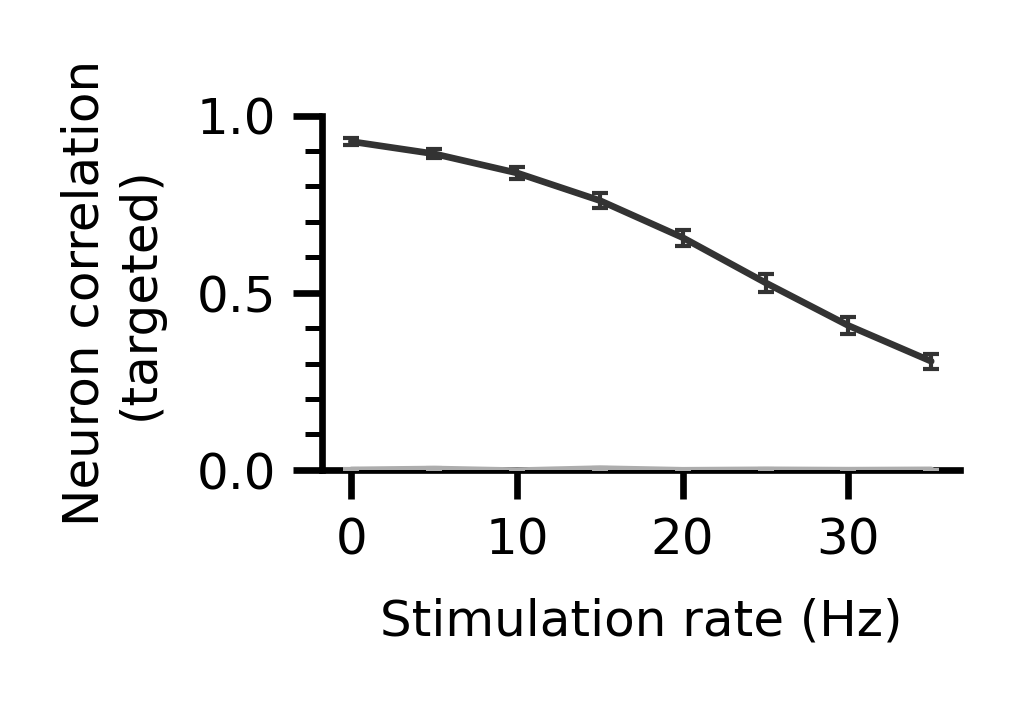

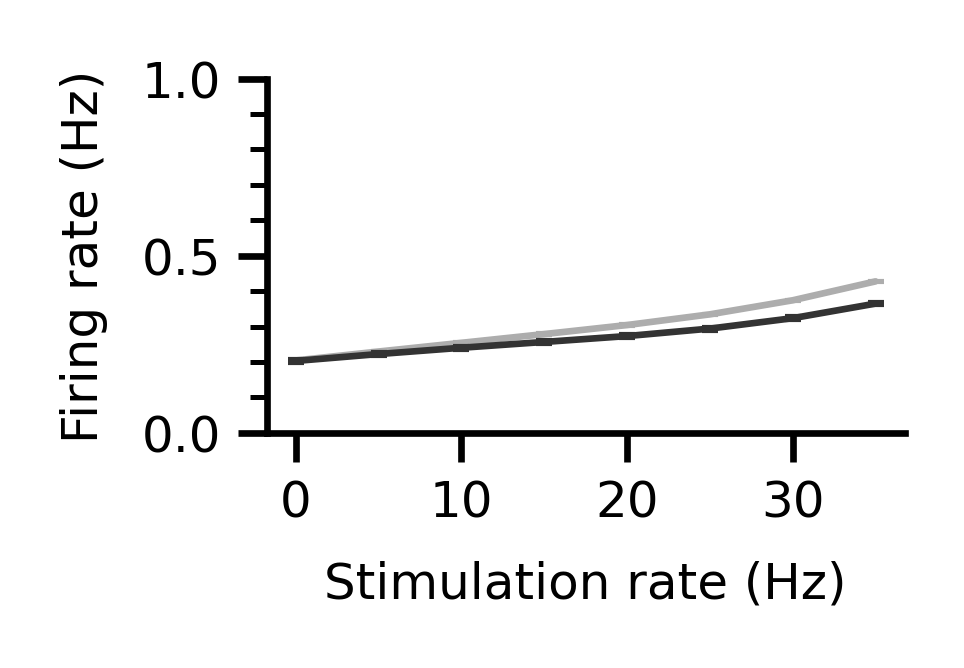

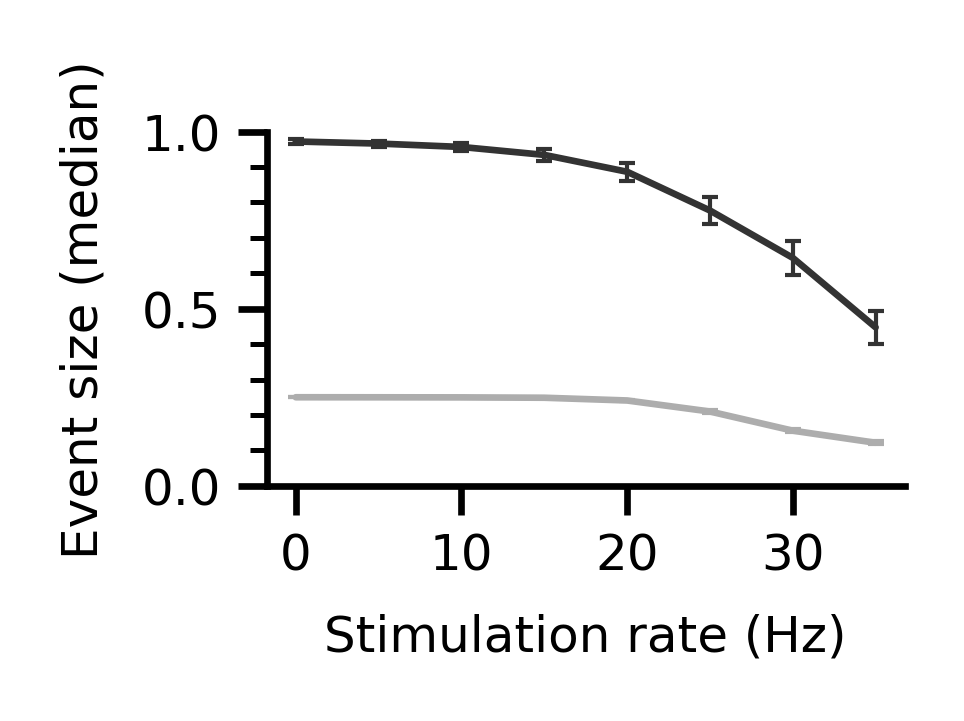

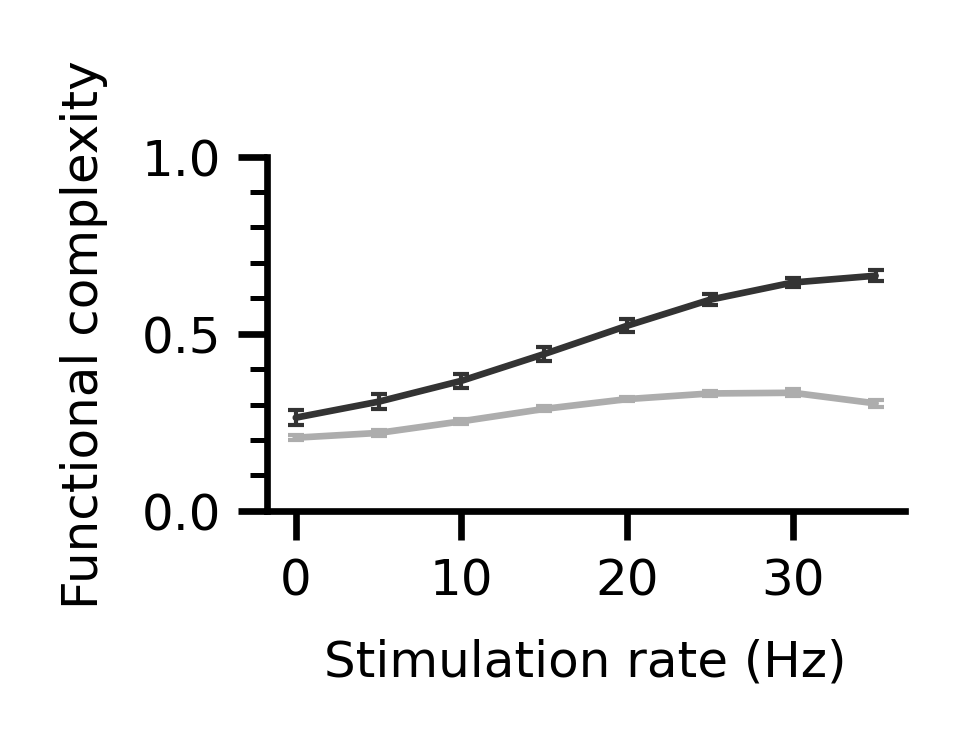

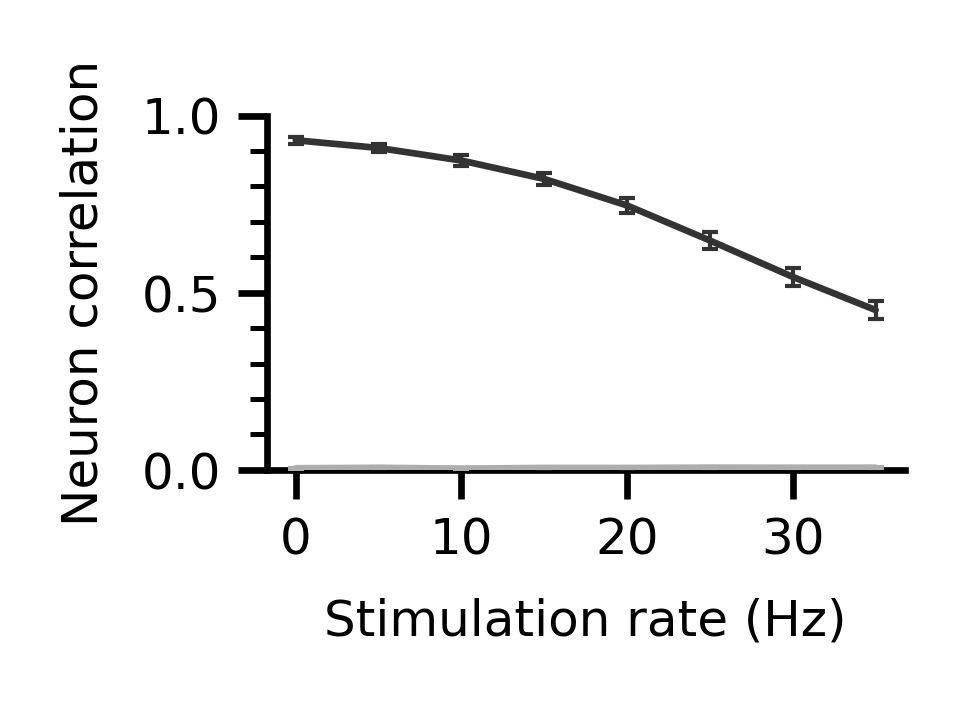

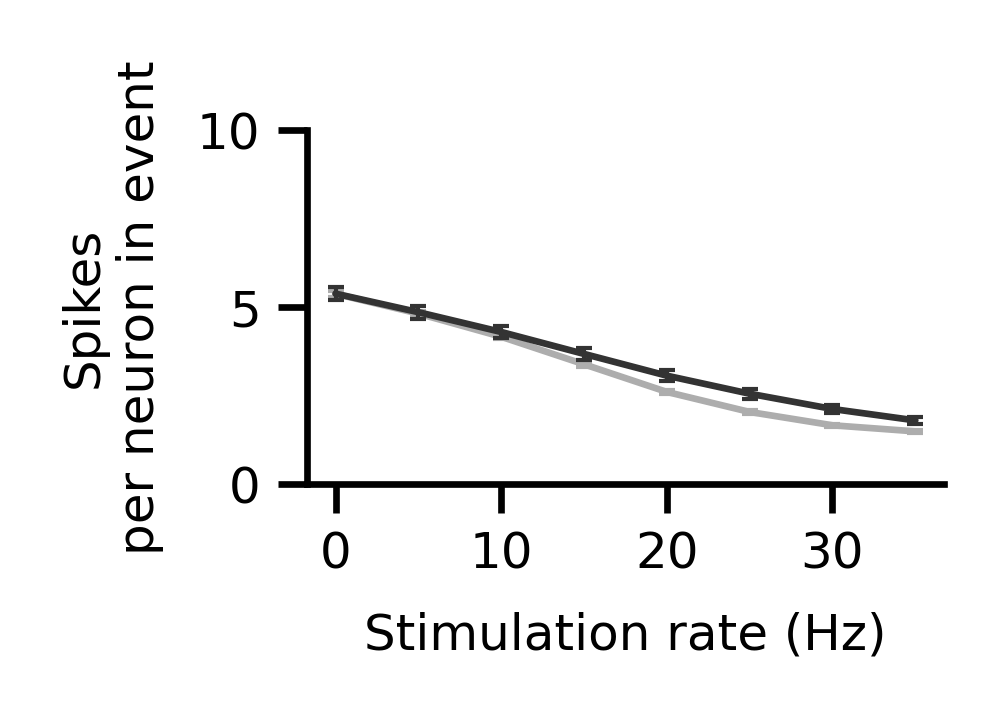

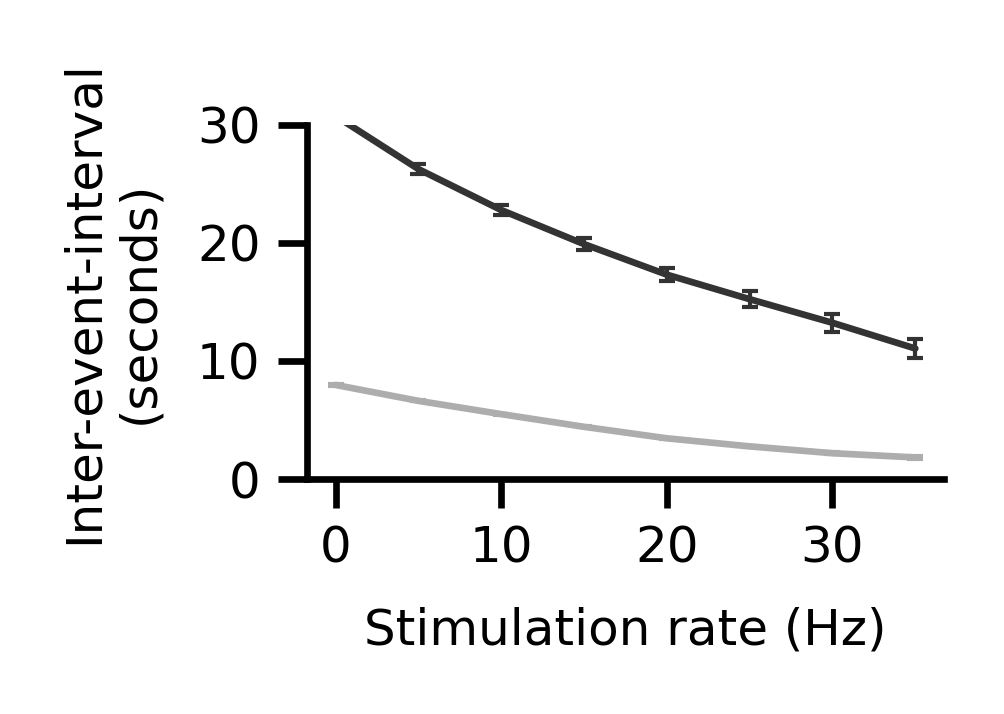

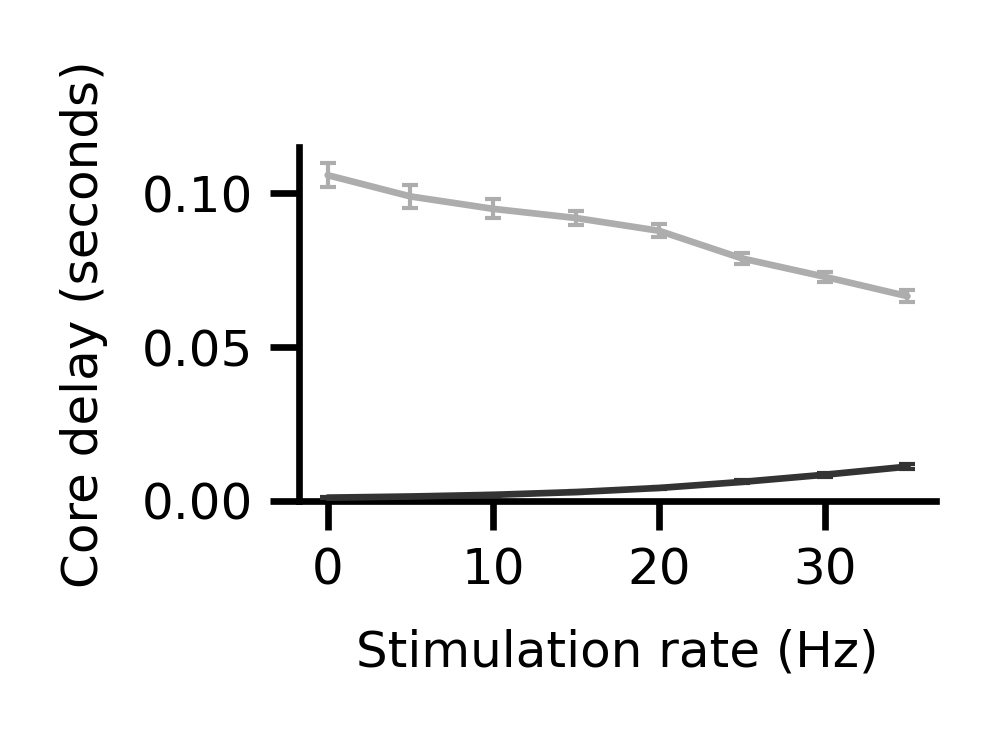

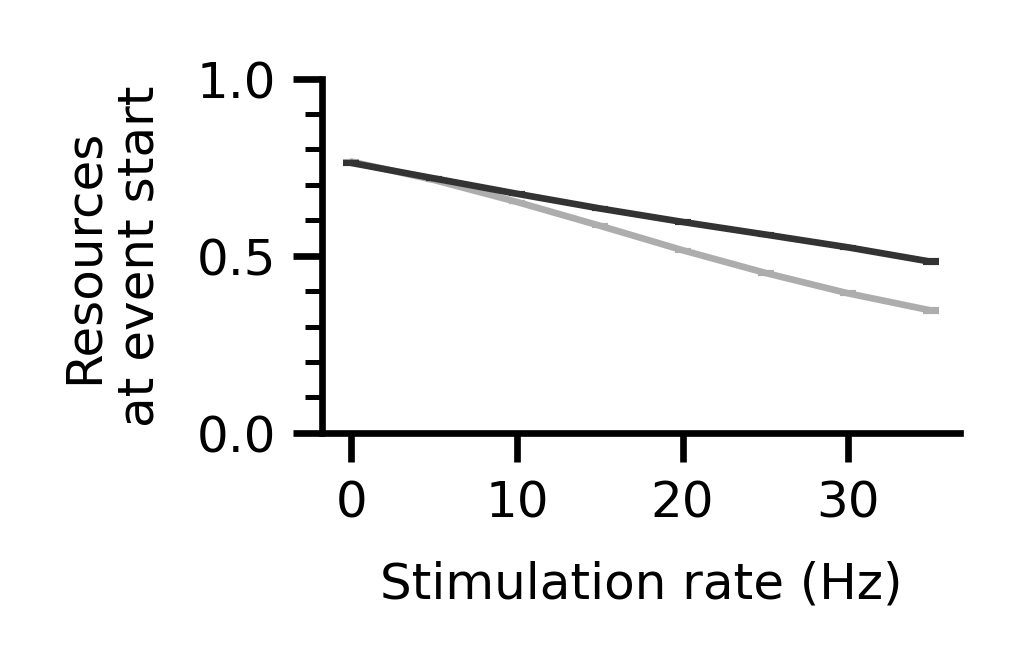

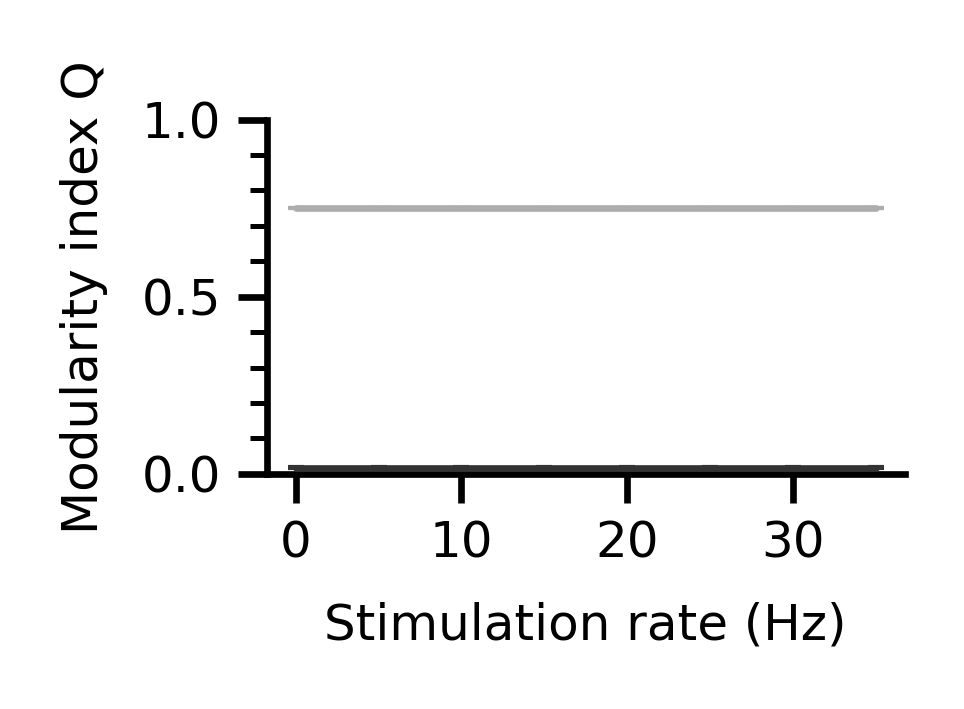

In [22]:
# A Reviewer reply: comparing k=0 to merged
pp.show_legend = False
pp.log.setLevel("ERROR")
pp.show_title = False
pp.show_ylabel = True
pp.show_xlabel = True
# requires hardcoding in the function definition, `iters`
pp.fig_4_r1(
    x_dim="stim_rate",
    out_prefix=f"{pp.p_fo}/sim_sr_0merged_",
)